# Részvényindexek EDA – Adathalmaz bemutatása

A 11. feladathoz tartozó adatot használom fel, a projektben a data mappába helyezvve.

Ebben a jegyzetfüzetben az `data/usa_stocks_data` könyvtárban található, nyilvánosan elérhető amerikai részvényindex-adatokat vizsgálom. A forrás tartalmazza a három nagy index (S&P 500, Dow Jones, Nasdaq-100) vállalati összetételét (`index/constituents`), az indexek historikus teljesítményét (`index/perf`), valamint több száz egyedi részvény napi árfolyam-sorozatát (`stock_prices`).

 - Forrás: a dataset az amerikai tőzsdéken jegyzett vállalatok nyilvános történeti adatait gyűjti össze CSV formában. A vállalati listák mezői (ticker, vállalatnév, szektor, iparág, alapítás éve stb.) közvetlenül felhasználhatók, míg az index- és árfolyam-fájlok időbélyeg + OHLCV struktúrát követnek.
 - Szerkezet: minden index/vállalati fájl első sora oszlopfejléceket tartalmaz, a rekordok soronkénti CSV formátumúak. A notebook során a `sp500.csv`-t használom elsődleges vállalati törzsadatként (mert naprakészebb és teljesebb metrikákat ad), míg az index teljesítményeket a `index/perf` almappából töltöm be `Date` indexeléssel.

A későbbi cellákban részletesen betöltöm, megtisztítom, majd EDA célokra elemezhető formátumba alakítom ezeket az adatokat.

In [251]:

import re
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import calendar

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from statsmodels.graphics.tsaplots import plot_acf

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment


from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
    f1_score, recall_score
)

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# ábrázolási beállítások
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

random_state = 42

print("Könyvtárak importálva!")

Könyvtárak importálva!


Könyvtárak elérési útjai

In [252]:
data_path = Path('data/usa_stocks_data')
constituents_path = data_path / 'index/constituents'
idxperf_path = data_path / 'index/perf'
stock_prices_path = data_path / 'stock_prices'


# Adatbetöltés és Adattisztítás
## S&P 500
### Forrásfájl kiválasztása
Amint látható, S&P 500 indexhez 2 fájl is található. Ezeket megvizsgálom, és a jelenlegi állapotához közelebbit használom a továbbiakban

In [253]:
sp500_companies1 = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)
sp500_companies2 = pd.read_csv(constituents_path / 'sp500_companies.csv', header=0, index_col=0)

# Szimbólumok összehasonlítása
print(f"sp500_companies.csv rekordjainak száma: {len(sp500_companies1)}")
print(f"sp500.csv rekordjainak száma: {len(sp500_companies2)}")

sp500_symbols = set(sp500_companies1['Symbol'].unique())
sp500_companies_symbols = set(sp500_companies2['Symbol'].unique())

print(f"\nSP500.csv egyedi szimbólumok száma: {len(sp500_symbols)}")
print(f"SP500_companies.csv egyedi szimbólumok száma: {len(sp500_companies_symbols)}")

# Szimbólumok, amelyek csak az egyikben vannak
only_sp500 = sp500_symbols - sp500_companies_symbols
only_sp500_companies = sp500_companies_symbols - sp500_symbols
common_symbols = sp500_symbols & sp500_companies_symbols

print(f"\nKözös szimbólumok: {len(common_symbols)}")
print(f"Csak SP500-ban lévő szimbólumokszáma: {len(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok száma: {len(only_sp500_companies)}")

print(f"\nCsak SP500-ban lévő szimbólumok: {list(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok: {list(only_sp500_companies)}")



sp500_companies.csv rekordjainak száma: 503
sp500.csv rekordjainak száma: 501

SP500.csv egyedi szimbólumok száma: 503
SP500_companies.csv egyedi szimbólumok száma: 501

Közös szimbólumok: 500
Csak SP500-ban lévő szimbólumokszáma: 3
Csak SP500_companies-ben lévő szimbólumok száma: 1

Csak SP500-ban lévő szimbólumok: ['VLTO', 'BX', 'ABNB']
Csak SP500_companies-ben lévő szimbólumok: ['NWL']


Azt, hogy nem 500 rekordot tartalmaznak a fájlok az magyarázza, hogy bizonyos cégeknek több osztályú részvénye is része a rekordoknak, pl.: GOOG (Class B), GOOGL (Class A)

In [254]:
#Attribútumok vizsgálata
print(f"\nsp500.csv oszlopok:\n {list(sp500_companies1.columns)}\n")
print(f"\nsp500_companies.csv oszlopok:\n {list(sp500_companies2.columns)}\n")


sp500.csv oszlopok:
 ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded', 'Shares Outstanding']


sp500_companies.csv oszlopok:
 ['Symbol', 'Company Name', 'Industry', 'Sector', 'Founded', 'shares outstanding']



A rekordok számának viszgálatából kiderült, hogy egyik fájlban sincs duplikált adat.

Az sp500_companies.csv-ben található egyedül az NWL (Newell Brands Inc.), ami 2023 szeptember 18.-án kikerült az indexből.
Az sp500.csv-ben található egyedül 'ABNB', 'VLTO', 'BX', (Airbnb, Inc., Blackstone Inc., Veralto Corp.), amik 2023 szeptember 18.-án, és 2023 október 2.-án kerültek fel az indexre.
Ezek alapján az sp500.csv aktuálisabb információt tartalmaz.

Emellet az sp500.csv több információt tartalmaz a cégekről, és összes sp500_companies.csv-ben találhtó attribútum is jelen van.

Tehát innentől az sp500.csv-t használom az S&P 500 teljesítményének vizsgálatára.


In [255]:
sp500_companies = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)

### Adatok tisztítása

Ebben a fejezetben az
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre
 - Átnevezek bizonyos oszlopokat, hogy a többi index oszlopával konzisztens legyem
 - *Founded* adatokból kinyerem a pontos évet minden rekord esetén

In [256]:
text_cols = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location']
for col in text_cols:
    sp500_companies[col] = sp500_companies[col].astype('string').str.strip()

#Indexek közötti konzisztencia érdekében
sp500_companies.rename(columns={'GICS Sector': 'Sector'}, inplace=True)
sp500_companies.rename(columns={'GICS Sub-Industry': 'Industry'}, inplace=True)

sp500_companies['Date added'] = pd.to_datetime(sp500_companies['Date added'], errors='coerce')
sp500_companies['CIK'] = sp500_companies['CIK'].astype(int)
sp500_companies['Shares Outstanding'] = sp500_companies['Shares Outstanding'].astype(int)

def extract_year(x):
    if pd.isna(x):
        return pd.NA
    years = [int(y) for y in re.findall(r'(\d{4})', str(x))]
    return min(years) if years else pd.NA

sp500_companies['Founded'] = sp500_companies['Founded'].apply(extract_year)
sp500_companies['Founded'] = pd.to_numeric(sp500_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata
Ebben a fejezetben:
 - Megvizsgálom, hogy hol hiányzok adat, és feltöltöm őket
 - Megvizsgálom a kategorikus változókat, és azt, hogy megfelel-e az iparban használtakkal

In [257]:
sp500_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   Sector                 503 non-null    string        
 3   Industry               502 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             491 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    int64         
dtypes: datetime64[ns](1), int64(3), string(5)
memory usage: 39.3 KB


Itt látható, hogy a Date added, és industry attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata:

 - Industry:

In [258]:
sp500_companies[sp500_companies["Industry"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
468,VLTO,Veralto,Industrials,<NA>,"Waltham, Massachusetts",2023-10-02,1967680,2023,246291005


Hiányzó adat: Environmental & Facilities Services, ennek hozzáadása

In [259]:
sp500_companies.loc[sp500_companies["Symbol"] == "VLTO", "Industry"] = "Environmental & Facilities Services"

 - Date added

In [260]:
sp500_companies[sp500_companies["Date added"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
156,D,Dominion Energy,Utilities,Electric Utilities,"Richmond, Virginia",NaT,715957,1983,836772984
186,ES,Eversource,Utilities,Multi-Utilities,"Hartford, Connecticut",NaT,72741,1966,349085992
211,FCX,Freeport-McMoRan,Materials,Copper,"Phoenix, Arizona",NaT,831259,1912,1433639982
243,HUM,Humana,Health Care,Managed Health Care,"Louisville, Kentucky",NaT,49071,1961,123906995
404,ROK,Rockwell Automation,Industrials,Electrical Components & Equipment,"Milwaukee, Wisconsin",NaT,1024478,1903,114860005
415,SRE,Sempra Energy,Utilities,Multi-Utilities,"San Diego, California",NaT,1032208,1998,629307049
435,TROW,T. Rowe Price,Financials,Asset Management & Custody Banks,"Baltimore, Maryland",NaT,1113169,1937,224295018
445,TXN,Texas Instruments,Information Technology,Semiconductors,"Dallas, Texas",NaT,97476,1930,907966030
457,USB,U.S. Bank,Financials,Diversified Banks,"Minneapolis, Minnesota",NaT,36104,1968,1556970036
482,WM,Waste Management,Industrials,Environmental & Facilities Services,"Houston, Texas",NaT,823768,1968,405059015


Hiányzó adatok hozzáadása:

In [261]:
missing_map = {
    "D":   "2016-11-30",
    "ES":  "2009-07-24",
    "FCX": "2011-07-01",
    "HUM": "2012-12-10",
    "ROK": "2000-03-12",
    "SRE": "2017-03-17",
    "TROW":"2019-07-29",
    "TXN": "2001-03-12",
    "USB": "1999-11-01",
    "WM":  "1998-08-31",
    "WY":  "1979-10-01",
    "WHR": "1959-04-01",
}

for sym, date in missing_map.items():
    sp500_companies.loc[(sp500_companies["Symbol"] == sym) & (sp500_companies["Date added"].isna()), "Date added"] = date

#### Kategórikus változók
 - Szektorok

In [262]:
print(f"Szektorok száma: {len(sp500_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {sp500_companies['Sector'].value_counts()}")

Szektorok száma: 11
Szektorok lebontása: Sector
Industrials               76
Financials                72
Health Care               65
Information Technology    64
Consumer Discretionary    52
Consumer Staples          38
Real Estate               31
Utilities                 30
Materials                 29
Communication Services    23
Energy                    23
Name: count, dtype: Int64


11 Szektorból található cég van az indexben, ami megfelel a GICS által meghatározott szektorok számának.

 - Iparágak

In [263]:
print(f"Iparágak száma: {len(sp500_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {sp500_companies['Industry'].value_counts()}")

Iparágak száma: 126
Iparágak lebontása: Industry
Health Care Equipment                           19
Semiconductors                                  15
Industrial Machinery & Supplies & Components    14
Application Software                            13
Electric Utilities                              13
                                                ..
Metal, Glass & Plastic Containers                1
Multi-Sector Holdings                            1
Computer & Electronics Retail                    1
Data Processing & Outsourced Services            1
Household Appliances                             1
Name: count, Length: 126, dtype: Int64


### S&P 500 teljesítményének betöltése

Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [264]:
#Date indexként használva
sp500_perf = pd.read_csv(idxperf_path / 'SP500_perf.csv', parse_dates=['Date'], header=0, index_col=0)


 - Típus konverziók

In [265]:
sp500_perf.index = pd.to_datetime(sp500_perf.index,utc=True, errors='coerce')
sp500_perf.index = sp500_perf.index.tz_convert("America/New_York")
sp500_perf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


Az index és az össze attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

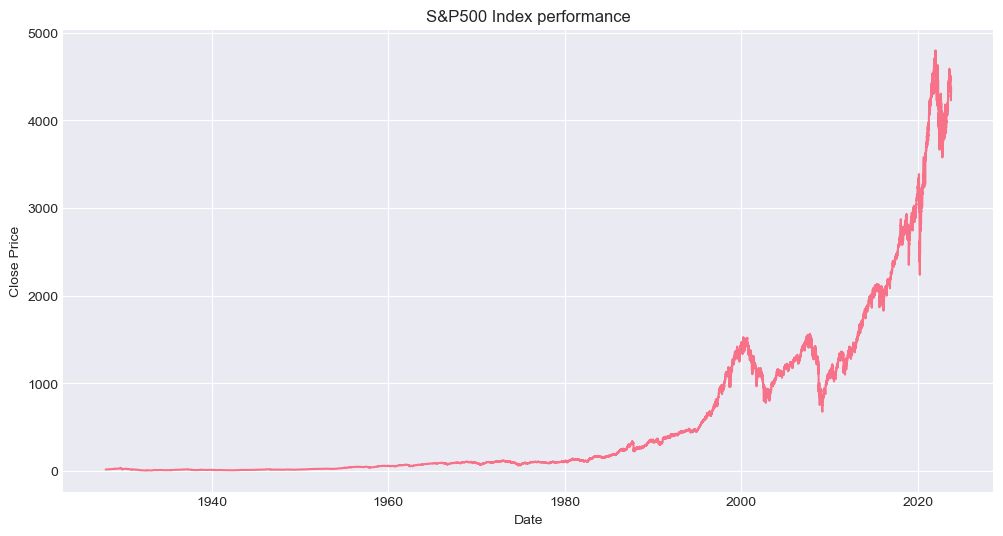

In [266]:
plt.plot(sp500_perf.index, sp500_perf["Close"])
plt.title("S&P500 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Nasdaq 100
### Adatok tisztítása

Ebben a fejezetben
 - Betöltöm az adatokat
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre


In [267]:
nasdaq100_companies = pd.read_csv(constituents_path / 'nasdaq100_companies.csv', header=0, index_col=0)

text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    nasdaq100_companies[col] = nasdaq100_companies[col].astype('string').str.strip()

nasdaq100_companies['Founded'] = pd.to_numeric(nasdaq100_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata

In [268]:
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             89 non-null     float64
 5   shares outstanding  101 non-null    float64
dtypes: float64(2), string(4)
memory usage: 5.5 KB


Itt látható, hogy a Founded, attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata
 - Founded

In [269]:
nasdaq100_companies[nasdaq100_companies["Founded"].isna()]

,Symbol,Company Name,Industry,Sector,Founded,shares outstanding
8,AVGO,Broadcom,Semiconductors,Technology,NaN,4.127360e+08
24,HON,Honeywell International,Conglomerates,Industrials,NaN,6.639610e+08
35,MDLZ,Mondelez International,Confectioners,Consumer Staples,NaN,1.360420e+09
45,CSX,CSX Corporation,Railroads,Industrials,NaN,2.006330e+09
52,MNST,Monster Beverage,Beverages - Non-Alcoholic,Consumer Staples,NaN,1.047520e+09
54,JD,JD.com,Internet Retail,Consumer Discretionary,NaN,1.573000e+09
66,ON,ON Semiconductor,Semiconductors,Technology,NaN,4.315290e+08
68,SGEN,Seagen,Biotechnology,Healthcare,NaN,1.876980e+08
69,EXC,Exelon,Utilities - Regulated Electric,Utilities,NaN,9.952191e+08
75,IDXX,IDEXX Laboratories,Diagnostics & Research,Healthcare,NaN,8.301240e+07


Hiányzó adatok hozzáadása:

In [270]:
missing_map = {
    "AVGO": 1961,
    "HON":  1885,
    "MDLZ": 1903,
    "CSX":  1980,
    "MNST": 1935,
    "JD":   1998,
    "ON":   1999,
    "SGEN": 1998,
    "EXC":  2000,
    "IDXX": 1983,
    "BKR":  1908,
    "SIRI": 2008
}

for sym, date in missing_map.items():
    nasdaq100_companies.loc[(nasdaq100_companies["Symbol"] == sym) & (nasdaq100_companies["Founded"].isna()), "Founded"] = date

nasdaq100_companies['Founded'] = nasdaq100_companies['Founded'].astype(int)

#### Kategórikus változók
Ebben a fejezetben
 - Átnevezek bizonyos attribútumokat, hogy konzisztens legyen a többi index-szel
 - Összehasonlítom, a már feldolgozott, S&P 500-zal


- Szektorok:

In [271]:
#Konzisztencia érdekében
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Healthcare", "Health Care")
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Technology", "Information Technology")

print(f"Szektorok száma: {len(nasdaq100_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {nasdaq100_companies['Sector'].value_counts()}")

Szektorok száma: 10
Szektorok lebontása: Sector
Information Technology    37
Consumer Discretionary    15
Health Care               15
Communication Services    10
Industrials                9
Consumer Staples           7
Utilities                  4
Energy                     2
Financials                 1
Real Estate                1
Name: count, dtype: Int64


Itt már nem jelenik meg mind a 11 szektor, de ez azért van, mert míg az S&P 500 500 céget, a Nasdaq csak 100-at tartalmaz és tech-irányult, ezért a *Materials* szektorból nem tartalmaz céget.

Megfelelés ellenőrzése:

In [272]:
print(f"Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? "
      f"{set(nasdaq100_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")


Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? True 


 - Iparágak:

In [273]:
print(f"Iparágak száma: {len(nasdaq100_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {nasdaq100_companies['Industry'].value_counts()}")

Iparágak száma: 45
Iparágak lebontása: Industry
Semiconductors                         13
Software - Application                  9
Software - Infrastructure               7
Internet Retail                         5
Semiconductor Equipment & Materials     4
Drug Manufacturers - General            4
Biotechnology                           4
Utilities - Regulated Electric          3
Internet Content & Information          3
Beverages - Non-Alcoholic               3
Telecom Services                        3
Entertainment                           3
Medical Devices                         2
Diagnostics & Research                  2
Apparel Retail                          2
Staffing & Employment Services          2
Travel Services                         2
Discount Stores                         2
Auto Manufacturers                      2
Packaged Foods                          1
Health Information Services             1
Oil & Gas E&P                           1
Industrial Distribution     

Hasonló okokból itt sincs jelen az összes, S&P 500-nál megfigyelt iparág

### Nasdaq 100 teljesítményeének betöltése

Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [274]:
# Date indexként használva
nasdaq100_perf = pd.read_csv(idxperf_path / 'Nasdaq100_perf.csv', parse_dates=['Date'], header=0, index_col=0)

 - Típus konverziók

In [275]:
nasdaq100_perf.index = pd.to_datetime(nasdaq100_perf.index,utc=True, errors='coerce')
nasdaq100_perf.index = nasdaq100_perf.index.tz_convert("America/New_York")
nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1 KB


Az index és az összes attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

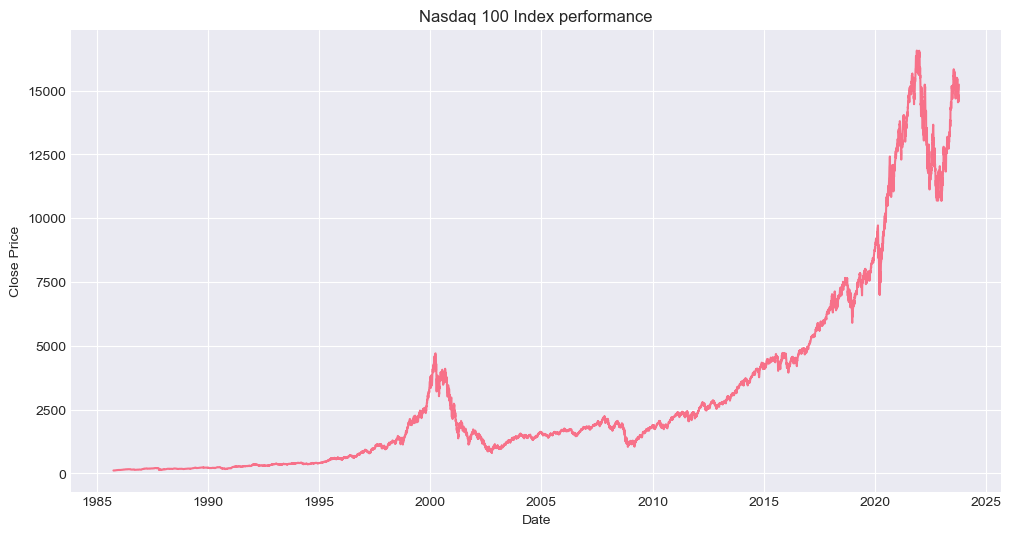

In [276]:
plt.plot(nasdaq100_perf.index, nasdaq100_perf["Close"])
plt.title("Nasdaq 100 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Dow Jones
### Adatok tisztítása

Ebben a fejezetben
 - Betöltöm az adatokat
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre

In [277]:
dowjones_companies = pd.read_csv(constituents_path / 'dowjones_companies.csv', header=0, index_col=0)

text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    dowjones_companies[col] = dowjones_companies[col].astype('string').str.strip()

dowjones_companies['Founded'] = pd.to_numeric(dowjones_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata

In [278]:
dowjones_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        30 non-null     string 
 1   Company Name  30 non-null     string 
 2   Industry      30 non-null     string 
 3   Sector        30 non-null     string 
 4   Founded       28 non-null     float64
dtypes: float64(1), string(4)
memory usage: 1.4 KB


Itt látható, hogy a Founded, attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata
 - Founded

In [279]:
dowjones_companies[dowjones_companies["Founded"].isna()]

,Symbol,Company Name,Industry,Sector,Founded
22,HON,Honeywell International,Conglomerates,Industrials,NaN
28,DOW,Dow Inc.,Chemicals,Materials,NaN


Hiányzó adatok hozzáadása:

In [280]:
missing_map = {
    "HON": 1906,
    "DOW":  1897
}

for sym, date in missing_map.items():
    dowjones_companies.loc[(dowjones_companies["Symbol"] == sym) & (dowjones_companies["Founded"].isna()), "Founded"] = date

dowjones_companies['Founded'] = dowjones_companies['Founded'].astype(int)

#### Kategórikus változók
Ebben a fejezetben
 - Átnevezek bizonyos attribútumokat, hogy konzisztens legyen a többi index-szel
 - Összehasonlítom, a már feldolgozott, S&P 500-zal


 - Szektorok

In [281]:
#Konzisztencia érdekében
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Healthcare", "Health Care")
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Technology", "Information Technology")

print(f"Szektorok száma: {len(dowjones_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {dowjones_companies['Sector'].value_counts()}")

Szektorok száma: 9
Szektorok lebontása: Sector
Information Technology    6
Financials                5
Health Care               5
Industrials               4
Consumer Staples          3
Consumer Discretionary    3
Communication Services    2
Energy                    1
Materials                 1
Name: count, dtype: Int64


Itt már nem jelenik meg mind a 11 szektor, de ez azért van, mert ez az index már csak 30 cégből áll.

Megfelelés ellenőrzése:

In [282]:
print(f"Dow Jones Industry-k megfelelnek az S&P 500 szektorainak? "
      f"{set(dowjones_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")

Dow Jones Industry-k megfelelnek az S&P 500 szektorainak? True 


 - Iparágak

In [283]:
print(f"Iparágak száma: {len(dowjones_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {dowjones_companies['Industry'].value_counts()}")

Iparágak száma: 26
Iparágak lebontása: Industry
Drug Manufacturers - General           3
Credit Services                        2
Conglomerates                          2
Consumer Electronics                   1
Entertainment                          1
Chemicals                              1
Insurance - Property & Casualty        1
Capital Markets                        1
Aerospace & Defense                    1
Information Technology Services        1
Telecom Services                       1
Farm & Heavy Construction Machinery    1
Footwear & Accessories                 1
Semiconductors                         1
Restaurants                            1
Software - Infrastructure              1
Software - Application                 1
Communication Equipment                1
Beverages - Non-Alcoholic              1
Home Improvement Retail                1
Oil & Gas Integrated                   1
Household & Personal Products          1
Banks - Diversified                    1
Discount 

### Dow Jones teljesítményének betöltése
Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [284]:
#Date indexként használva
dowjones_perf = pd.read_csv(idxperf_path / 'Dow_Jones_perf.csv', parse_dates=['Date'], header=0, index_col=0)

 - Típus konverziók

In [285]:
dowjones_perf.index = pd.to_datetime(dowjones_perf.index, utc=True, errors="coerce")
dowjones_perf.index = dowjones_perf.index.tz_convert("America/New_York")
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2 KB


Az index és az összes attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

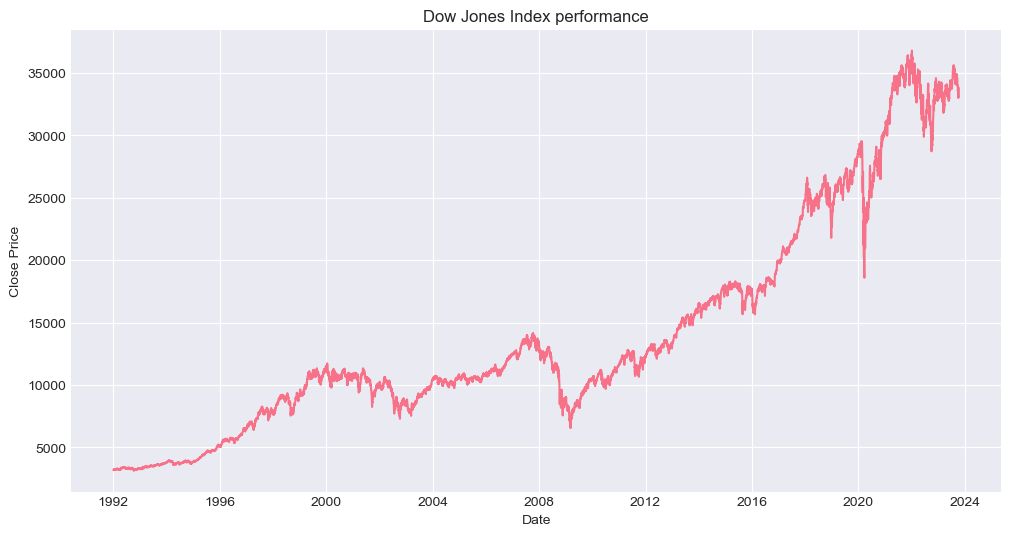

In [286]:
plt.plot(dowjones_perf.index, dowjones_perf["Close"])
plt.title("Dow Jones Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Inflációs adatok
Ebben a fejezetben
 - Betöltöm az adatokat
 - Elforgatom a táblázatot, hogy kezelhetőbb legyen
 - Oszlopok típusát állítom be helyesre

In [287]:
inflation_temp = pd.read_csv(data_path / 'usd_inflation.csv', parse_dates=['Year'], header=0)
inflation_temp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,1914-01-01,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
1,1915-01-01,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0
2,1916-01-01,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9
3,1917-01-01,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4
4,1918-01-01,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0


### Adatok tisztítása
 - Elforgatás

Felül látható, hogy 1 sor = 1 év 12 hónapra és azok átlaga. Ez megjelenítésre alkalmatlan, tehát elforgatom úgy, hogy 1 sorban legyen 1 hónap inflációs adata.
Egy sorban az adat dátuma (indexként), és maga az adat lesz.

In [288]:
inflation = inflation_temp.melt(
    id_vars=["Year"],
    value_vars=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    var_name="Month",
    value_name="Inflation"
)
inflation["Year"] = pd.to_datetime(inflation["Year"]).dt.year

# dátum aggregálása egy attribútumba
inflation["Date"] = pd.to_datetime(inflation["Year"].astype(str) + "-" + inflation["Month"], format="%Y-%b")
inflation = inflation[["Date","Inflation"]].sort_values("Date").reset_index(drop=True)
inflation = inflation.set_index("Date")

# azon sorok elhagyása amikhez nincs inflációs adat (2023 vége)
inflation = inflation.dropna(subset=["Inflation"])
inflation.index = inflation.index.tz_localize('America/New_York')

inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1316 entries, 1914-01-01 00:00:00-05:00 to 2023-08-01 00:00:00-04:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  1316 non-null   float64
dtypes: float64(1)
memory usage: 20.6 KB


Az infláció és az index attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

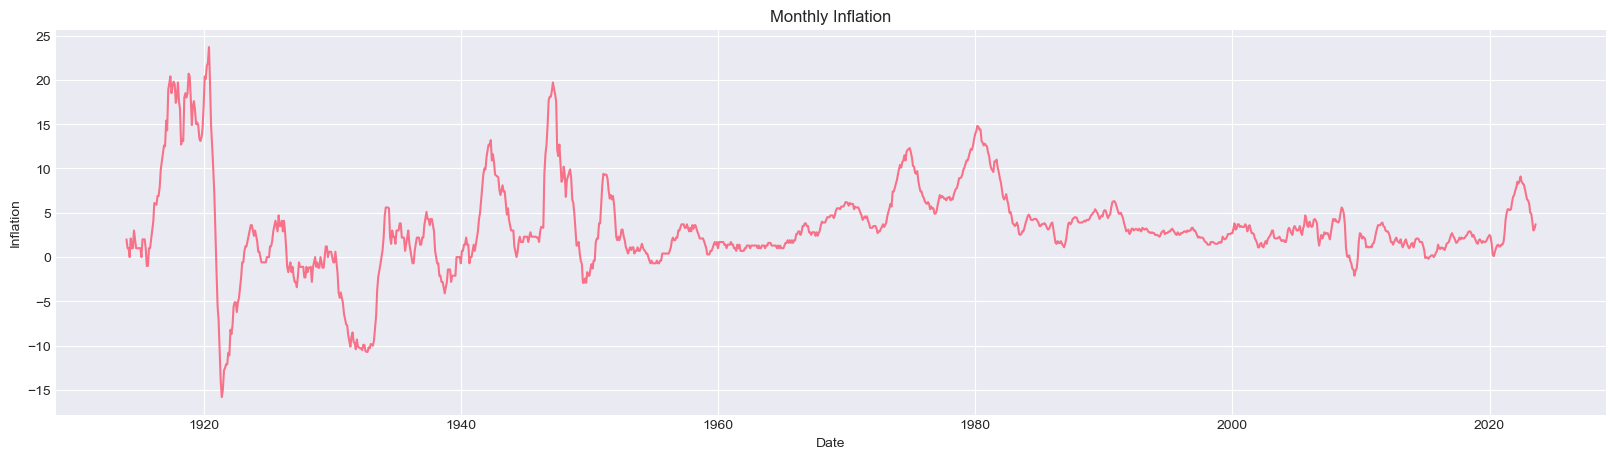

In [289]:
plt.figure(figsize=(20,5))
plt.plot(inflation.index, inflation["Inflation"])
plt.title("Monthly Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.show()

## Részvények

Ebben a fejezetben
 - Ismertetem az adatok struktúráját
 - Cikusban betöltöm az összes részvényt

### Teszt egy részvényen

In [290]:
teststock = pd.read_csv('data/usa_stocks_data/stock_prices/TSLA.csv', header=0, index_col=0)
teststock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3345 entries, 2010-06-29 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3345 non-null   float64
 1   High          3345 non-null   float64
 2   Low           3345 non-null   float64
 3   Close         3345 non-null   float64
 4   Volume        3345 non-null   int64  
 5   Dividends     3345 non-null   float64
 6   Stock Splits  3345 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 209.1+ KB


Látható, hogy az adattípusok, az indexen kívül, megfelelnek az elvártaknak, és nem hiányzik adat

 - Típus konverziók

In [291]:
teststock.index = pd.to_datetime(teststock.index, utc=True, errors="coerce")
teststock.index = teststock.index.tz_convert("America/New_York")
teststock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3345 entries, 2010-06-29 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3345 non-null   float64
 1   High          3345 non-null   float64
 2   Low           3345 non-null   float64
 3   Close         3345 non-null   float64
 4   Volume        3345 non-null   int64  
 5   Dividends     3345 non-null   float64
 6   Stock Splits  3345 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 209.1 KB


### Összes részvény adat betöltése

Ebben a fejezetben az összes részvény adatát betöltöm
   - *stocks* tömb: Összes betöltött részvény szimbóluma
   - *prices* dictionary: összes részvény adata, kulcs a részvény szimbóluma

In [292]:
folder = Path("data/usa_stocks_data/stock_prices/")

prices = {}
stocks = []

for csv_file in folder.glob("*.csv"):
    symbol = csv_file.stem  
    df = pd.read_csv(csv_file, header=0, index_col=0)

    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    df.index = df.index.tz_convert("America/New_York")

    stocks.append(symbol)
    prices[symbol] = df

- Ellenőrzés

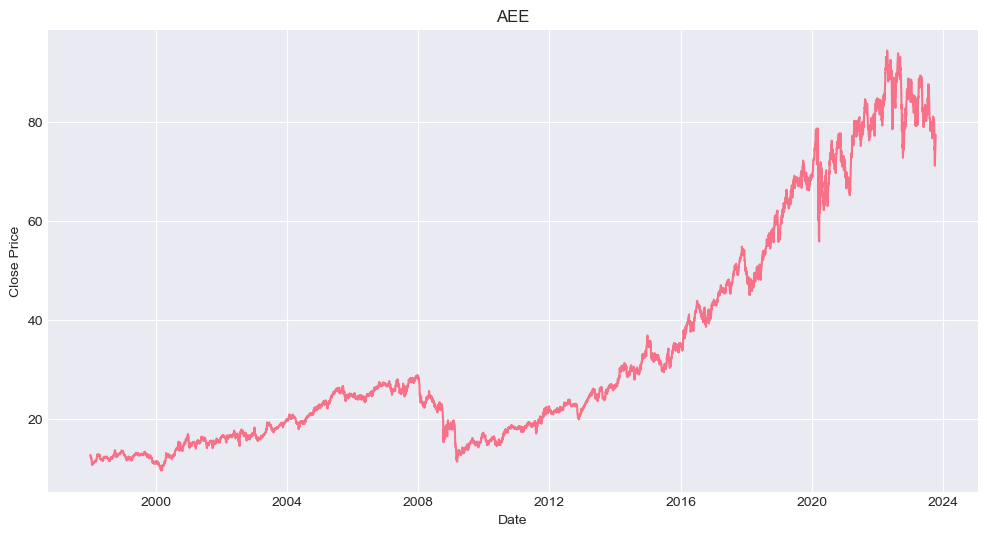

In [293]:
current_stock = stocks[13]
plt.plot(prices[current_stock].index, prices[current_stock]["Close"])
plt.title(current_stock)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


# Adatok vizsgálata

Ebben a fejezetben az EDA utolsó lépései következnek, a betöltött adatok alapvető tulajdonságainak vizsgálata

## Idősorok vizsgálata

Megvizsgálom, hogy az adatok milyen részletességgel és meddigre visszamenőleg állnak rendelkezésre adatok
### Indexek

In [294]:
indeces = {
    'S&P 500': sp500_perf,
    'Nasdaq 100': nasdaq100_perf,
    'Dow Jones': dowjones_perf
}
data_list = []

for name, idx in indeces.items():
    start = idx.index.min().date()
    end = idx.index.max().date()
    duration = round((end - start).days / 365, 1)
    delta = idx.index.to_series().diff().value_counts().sort_index()


    data_list.append({
        'Index neve': name,
        'Kezdet': start,
        'Vége': end,
        'Időtartam (év)': duration,
        'Adatpontok száma': len(idx),
        'Részletesség (nap)': min(delta)
    })

df_summary = pd.DataFrame(data_list)
df_summary.set_index('Index neve', inplace=True)

display(df_summary)

,Kezdet,Vége,Időtartam (év),Adatpontok száma,Részletesség (nap)
Index neve,,,,,
S&P 500,1927-12-30,2023-10-11,95.8,24060,1
Nasdaq 100,1985-10-01,2023-10-11,38.1,9585,1
Dow Jones,1992-01-02,2023-10-11,31.8,8004,1


Látható, hogy az összes index napi részletességgel van jelen, az indexek közül, pedig az S&P 500 messze a legrégebbi, majd ezt a 80-as években bejegyzett Nasdaq 100, és a 90-es években létrehozott Dow Jones követi.

### Részvények

Összesen 1 különböző részletesség van az adatokban : [1] (nap)


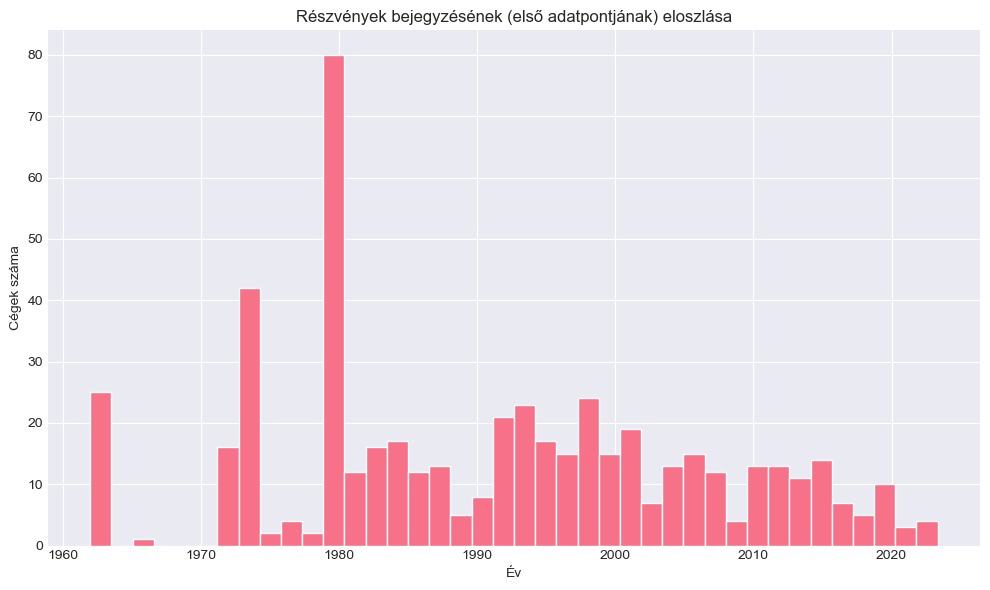

In [295]:
ipo = []
deltas = set()

for ticker, idx in prices.items():
    if not idx.empty:
        ipo.append(idx.index.min())

        # részletesség meghatározása
        delta = idx.index.to_series().diff().value_counts()
        most_frequent_delta = delta.idxmax().days
        deltas.add(most_frequent_delta)

print(f"Összesen {len(deltas)} különböző részletesség van az adatokban : {list(deltas)} (nap)")

#Hisztogram
plt.figure(figsize=(10, 6))
plt.hist(ipo, bins=40)

plt.title('Részvények bejegyzésének (első adatpontjának) eloszlása')
plt.xlabel('Év')
plt.ylabel('Cégek száma')

plt.tight_layout()
plt.show()

## Szektorok eloszlása

Itt megvizsgálom a szektorokban található cégek számát, ami a későbbi klaszterezésnél fontos lehet.


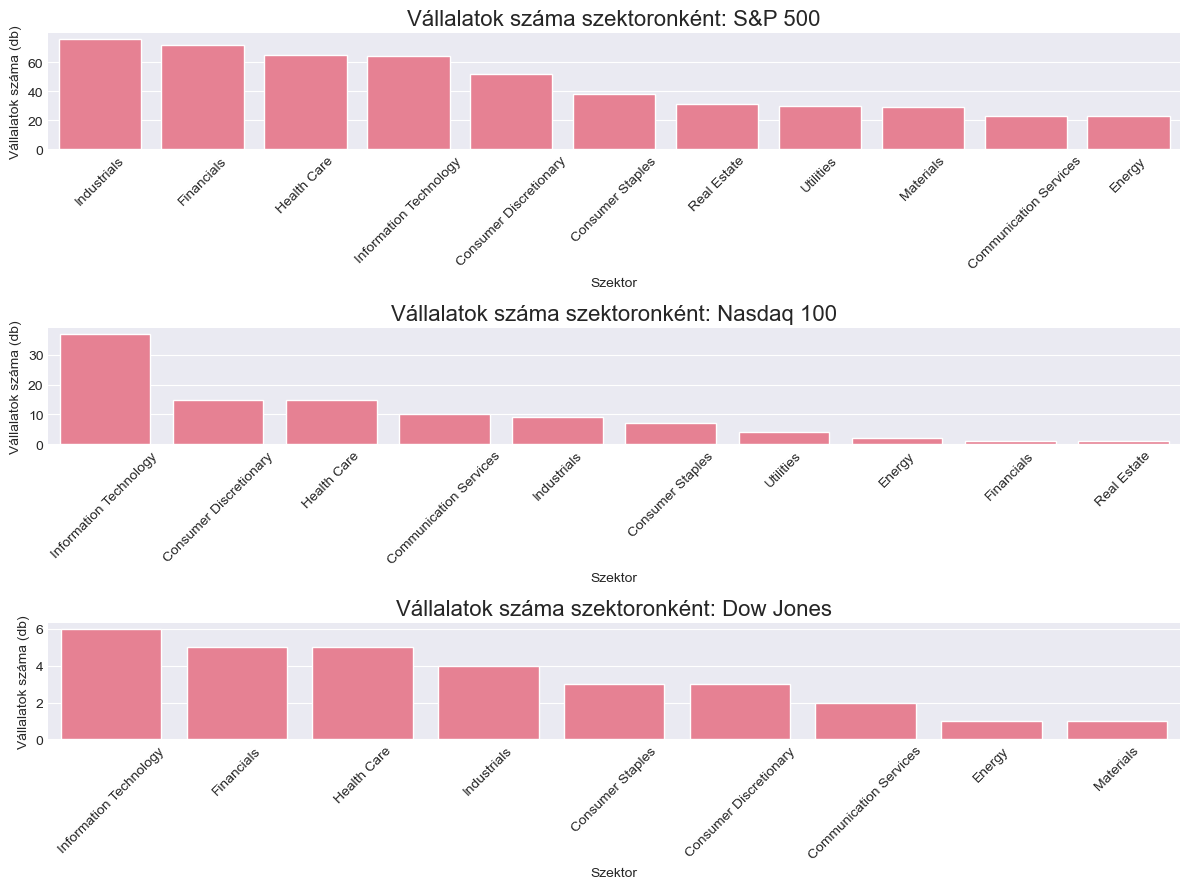

In [296]:
indeces_constituents = {
    'S&P 500': sp500_companies,
    'Nasdaq 100': nasdaq100_companies,
    'Dow Jones': dowjones_companies
}

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

for i, (name, idx) in enumerate(indeces_constituents.items()):
    sector_counts = idx['Sector'].value_counts().sort_values(ascending=False)
    sns.barplot(x=sector_counts.index, y=sector_counts.values, ax=axs[i])
    axs[i].set_title(f"Vállalatok száma szektoronként: {name}", fontsize=16)
    axs[i].set_xlabel('Szektor')
    axs[i].set_ylabel('Vállalatok száma (db)')
    axs[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Megfigyelések:

Nasdaq-100: Az ábrán látható, hogy a Nasdaq-100 indexet az Information Technology szektor dominálja.

S&P 500: Az S&P 500 esetében sokkal egyenletesebb a szektorok eloszlása. Ez indokolja, hogy miért ezt az indexet tekintjük a piac általános "benchmarkjának".

Dow Jones korlátai: A Dow Jones mindössze 30 vállalatot tartalmaz, így itt bizonyos szektorok (pl. Real Estate vagy Utilities) teljesen hiányozhatnak. Ezért a klaszterezési algoritmusoknál a Dow Jones adataitól várhatjuk a legkevesebb "zajt", de a legkisebb statisztikai reprezentativitást is

## Indexek hozama
### Éves hozamok

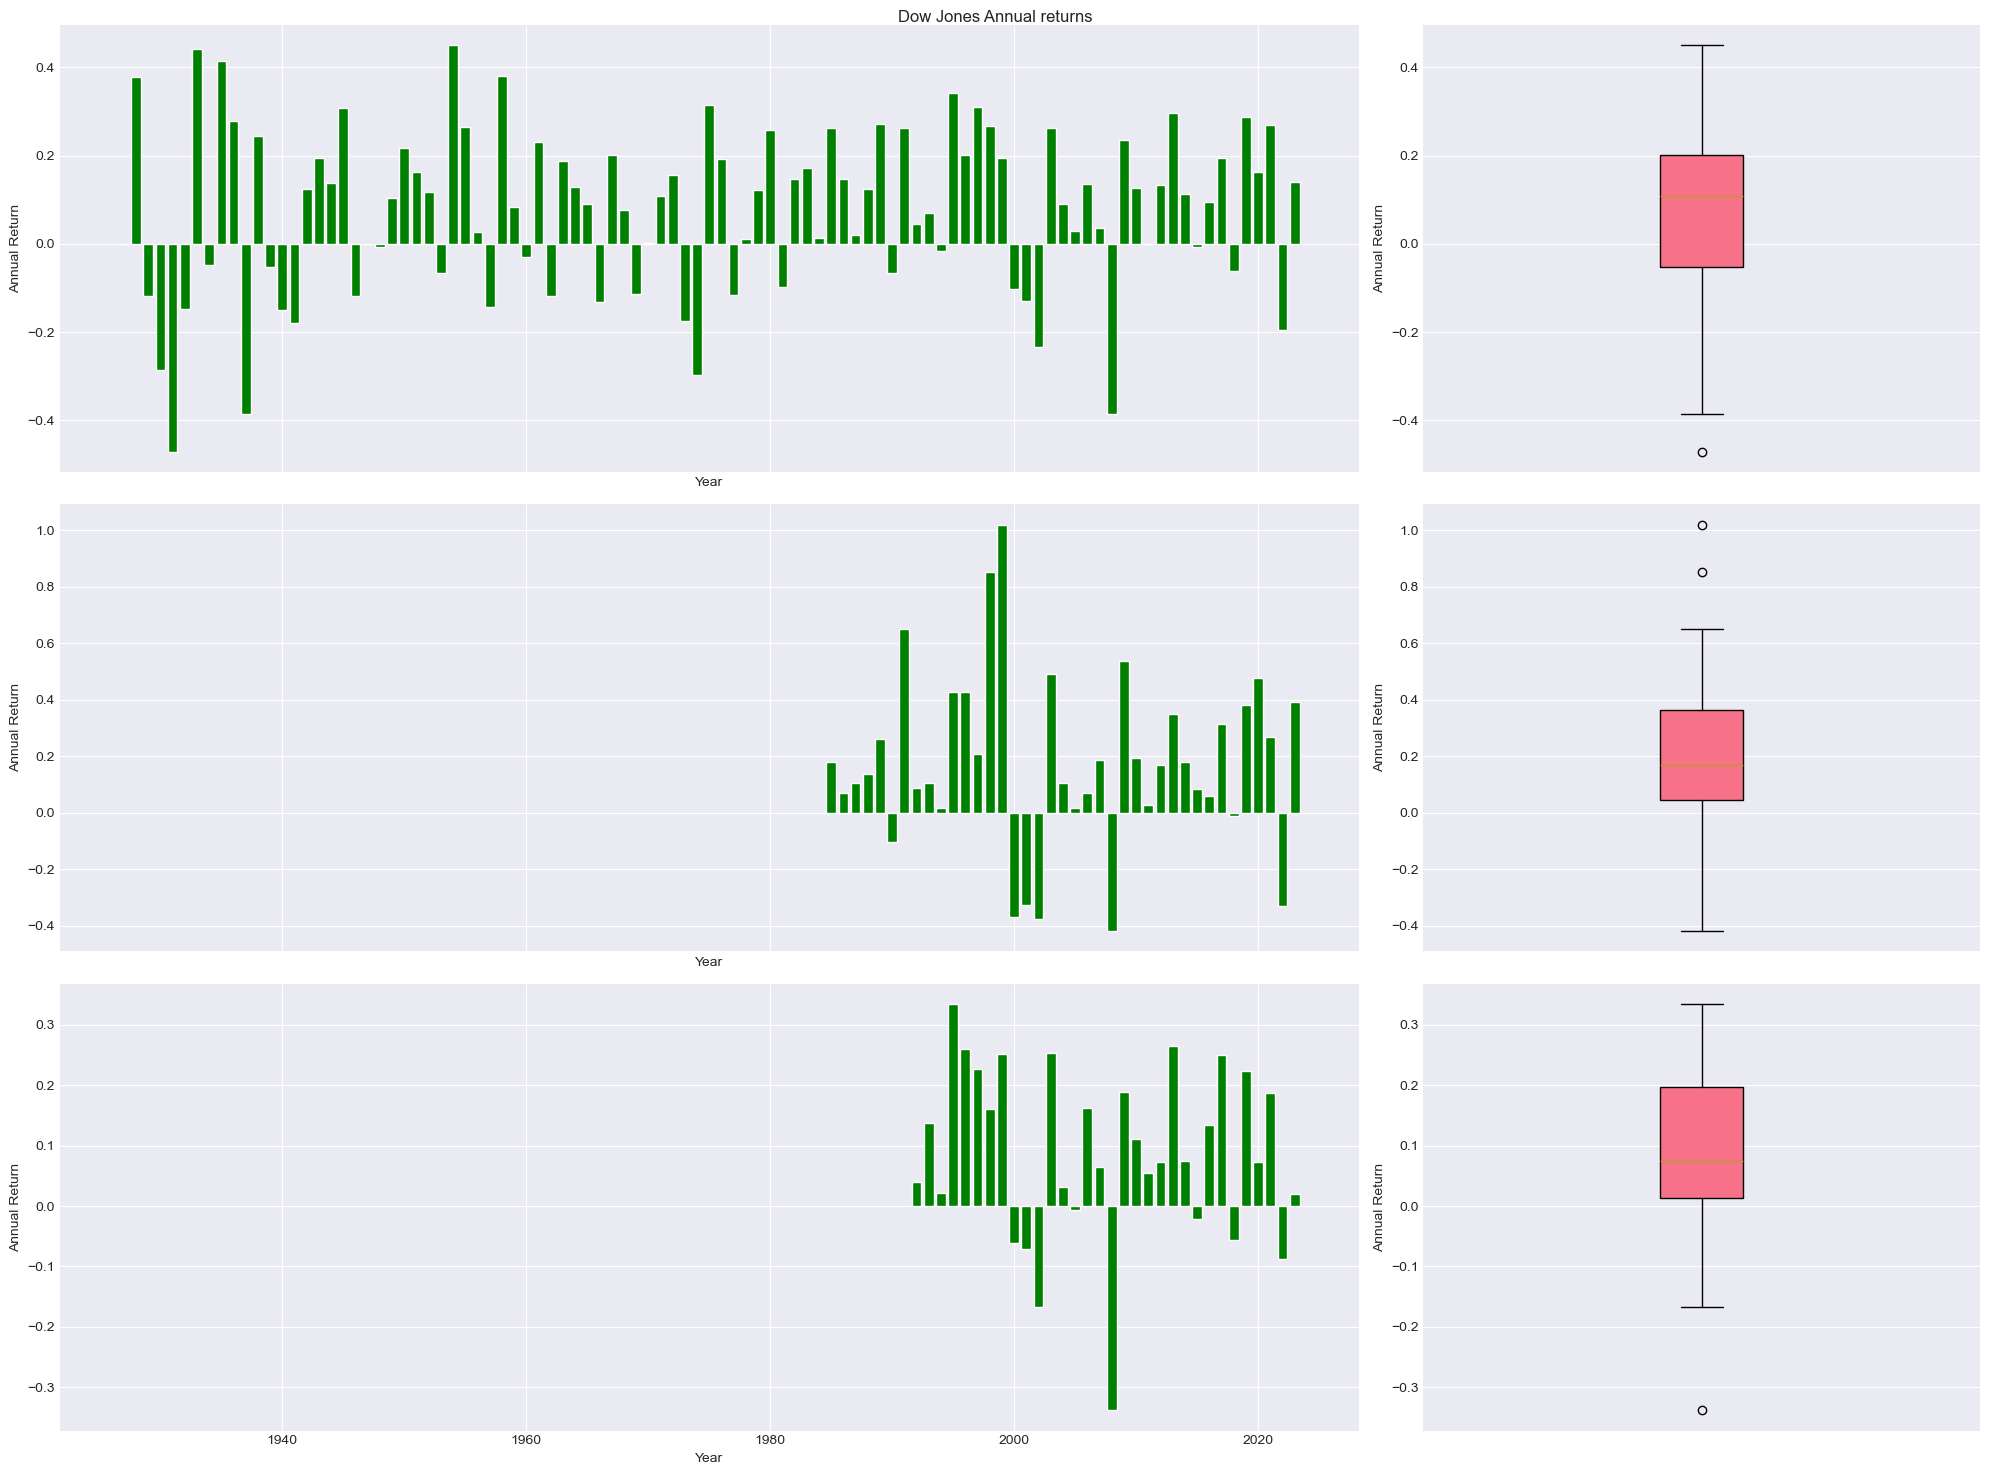

In [319]:
fig, axs = plt.subplots(3, 2, figsize=(20,15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
for i, (name, idx) in enumerate(indeces.items()):
    idx['Return'] = idx['Close'].pct_change()
    annual_return = (1 + idx['Return']).resample('Y').prod() - 1

    fig.suptitle(f"{name} Annual returns")

    axs[i,0].bar(annual_return.index.year, annual_return.values, color='green')
    axs[i,0].set_xlabel("Year")
    axs[i,0].set_ylabel("Annual Return")
    axs[i,0].grid(True, axis='y')

    axs[i,1].boxplot(annual_return.values, vert=True, patch_artist=True)
    axs[i,1].set_ylabel("Annual Return")
    axs[i,1].set_xticks([])
    axs[i,1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Általános tendenciák:
- A három index hosszú távon pozitív hozamot mutat, bár jelentős évenkénti ingadozásokkal.
- A boxplotok mutatják, hogy az éves hozamok eloszlása aszimmetrikus: több pozitív év van, mint negatív, ami a részvénypiac hosszú távú növekedési trendjét tükrözi.

Index-specifikus megfigyelések:
- S&P 500: A leghosszabb idősorral rendelkezik (1927-től), így tartalmazza a legtöbb történelmi eseményt (pl. 1929-es válság, olaj-válság, 2008-as pénzügyi válság). A volatilitás a boxplot alapján viszonylag stabil.
- Nasdaq 100: Technológiai orientációja miatt általában magasabb volatilitást mutat, és gyakran erősebb növekedési periódusokat mutat (pl. dot-com buborék, 2020-as tech rally).
- Dow Jones: A legrövidebb idősorral rendelkezik (1992-től), de a 30 nagyvállalat összetétele miatt általában stabilabb hozamokat mutat.

Kockázati tényezők:
- A negatív évek (pl. 2008, 2022) mindhárom indexnél egyértelműen láthatók, és gyakran makrogazdasági válságokhoz köthetők.


### Hozamok eloszlása

A következő cella a napi hozamok eloszlását ábrázolja a ferdeség és csúcsosság értékeivel együtt.

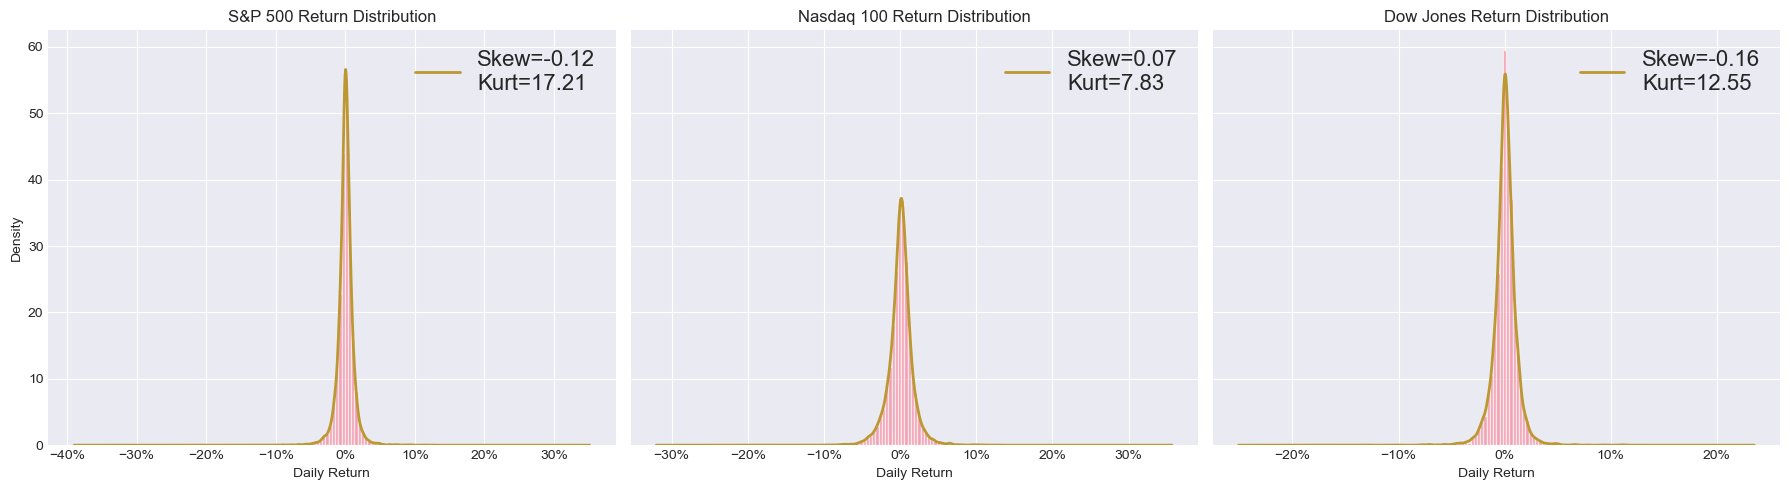

In [298]:
returns = pd.DataFrame({
    'S&P 500': sp500_perf['Return'].dropna(),
    'Nasdaq 100': nasdaq100_perf['Return'].dropna(),
    'Dow Jones': dowjones_perf['Return'].dropna()

})

fig, ax = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for i, name in enumerate(returns.columns):
    skew = returns[name].skew()
    kurt = returns[name].kurtosis()

    ax[i].hist(returns[name], bins=80, density=True, alpha=0.6)

    returns[name].plot(kind='kde', ax=ax[i], linewidth=2, label=f'Skew={skew:.2f}\nKurt={kurt:.2f}')

    ax[i].set_title(f"{name} Return Distribution")
    ax[i].set_xlabel("Daily Return")
    ax[i].set_ylabel("Density")
    ax[i].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax[i].legend(fontsize=16)

plt.tight_layout()
plt.show()

A negatív ferdeség (S&P 500, DOW) tipikus a pénzügyi piacokon, mivel a pánik és a nagy eladási hullámok általában gyorsabbak és mélyebbek, mint a hosszan tartó, stabil emelkedések. Mindhárom index hozama *leptokurtikus* mivek csúcsosság mindegyiknél nagyobb mint 3, ami jellemző a pénzügyi adatokra. Ez azt jelenti, hogy az 'extrém' értékeknek nagyobb esélyük van.

S&P 500 mutatja a legnagyobb kockázatot a szélsőséges események szempontjából, mivel az ő csúcsossága a legmagasabb (17.25).

Mind a S&P 500, mind a DOW enyhe baloldali ferdeséget mutat, ami azt jelzi, hogy a nagy negatív meglepetések valószínűbbek, mint a nagy pozitív meglepetések.

A NASDAQ hozamai állnak a legközelebb a szimmetrikus eloszláshoz, de a magas csúcsosság (7.83) itt is figyelmeztet a ritka, de potenciálisan súlyos események kockázatára.

## Indexek korrelációja

In [299]:
returns = pd.DataFrame({
    'S&P 500': sp500_perf['Return'].dropna(),
    'Nasdaq 100': nasdaq100_perf['Return'].dropna(),
    'Dow Jones': dowjones_perf['Return'].dropna()

})
corr_pairs = returns.corr().unstack()
unique_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()

print("Indexek közötti korreláció:")

for (i, j), val in unique_pairs.items():
    print(f"{i} <-> {j} : {val:.3f}")

Indexek közötti korreláció:
S&P 500 <-> Nasdaq 100 : 0.837
S&P 500 <-> Dow Jones : 0.962
Nasdaq 100 <-> Dow Jones : 0.748


 - S&P 500 - Dow Jones: 0.962 Ez majdnem tökéletes korreláció, ami a nagy átfedésnek, és a két index hasonló felépítésének köszönhető.
 - S&P 500 - Nasdaq 100: 0.837 Ez már nem olyan magas mint az előbb, de még mindig erős. Ez a különbség részben magarázható azzal, hogy a Nasdaq inkább tech súlyú.
 - Nasdaq 100 - Dow Jones: 0.748: Ez a legkisebb, de azért még midnig erős korreláció. Ez is azzal magyarázható, hogy a nasdaq főleg technológiai,Ez a különbség részben magarázható azzal, hogy a Nasdaq inkább tech súlyú, a Dow pedig inkább hagyományos ipari, és blue chip cégeket tartalmaz.
 - Domináns piaci trend: Az összes érték 0,7 feletti, ami egyértelműen erős kapcsolatot jelent, így egy általános piaci esés esetén az indexek közötti diverzifikáció csak korlátozott védelmet nyújt.

## Részvények korrelációja
Ebben a fejezetben megvizsgálom a részvények közti korrelációk eloszlását

Logaritmikus hozam: Előnyös, mert az adatok időben összeadhatóak, és jobban közelítik a statisztikai számításokhoz szükséges normális eloszlást. Emellett kiküszöböli a százalékos számítás torzítását, így szimmetrikusan és pontosabban kezeli a nagy arányú áreséseket és emelkedéseket.


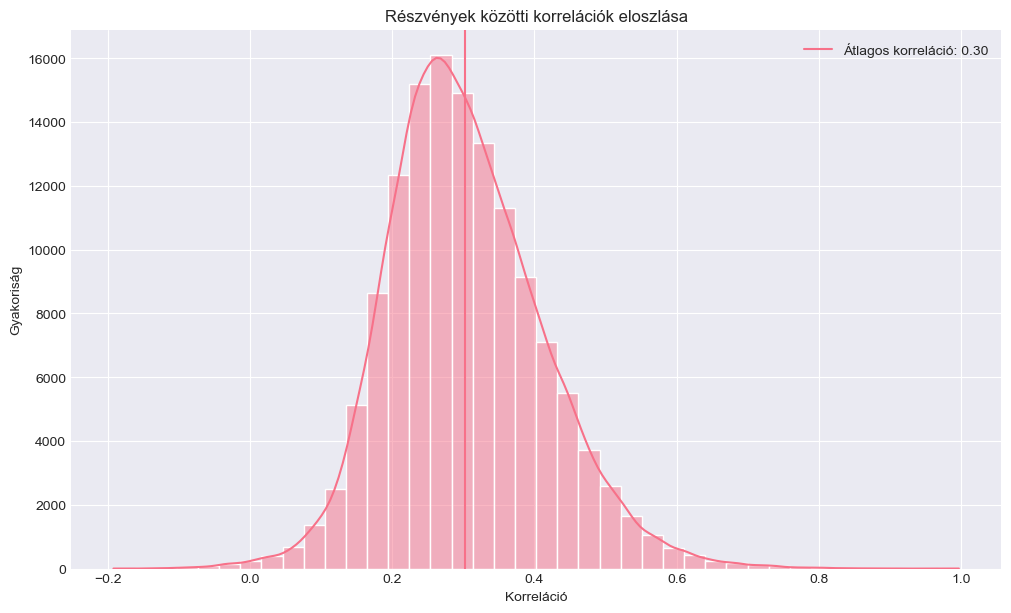

In [320]:
close_prices = pd.DataFrame({symbol: df['Close'] for symbol, df in prices.items()})

returns_stocks = np.log(close_prices / close_prices.shift(1))
##Páronkénti korreláció, mert minden részvény különböző pontban lett listázva (nem lehet dropna)
corr_matrix = returns_stocks.corr()

# Adatok tisztítása (csak a főátló feletti értékek)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_values = corr_matrix.where(mask).stack()

plt.figure(figsize=(12, 7))

sns.histplot(corr_values, bins=40, kde=True)

plt.axvline(corr_values.mean(), label=f'Átlagos korreláció: {corr_values.mean():.2f}')

plt.title('Részvények közötti korrelációk eloszlása')
plt.xlabel('Korreláció')
plt.ylabel('Gyakoriság')
plt.legend()

plt.show()

 - Pozitív piaci együttmozgás: Az adatok egyértelműen pozitív eltolódást mutatnak, ahol a korrelációk átlaga 0.30, ami jelzi, hogy a részvények többsége hajlamos egyszerre, azonos irányba mozogni.
 - Diverzifikációs potenciál: Bár a legtöbb érték a 0.1 és 0.5 közötti tartományba esik, a bal oldali farok jelenléte lehetőséget ad a kockázatcsökkentő portfólióépítésre.

Észrevételek:
 - Csoportosulás: Az, hogy a korrelációk ilyen szűk sávban csoportosulnak, lehetőséget ad arra, hogy a csoprotokat tovább vizsgáljam a későbbiekben.
 - Kiugró értékek: Későbbi vizsgálat során érdemes lehet megvizsgálni a 0.1 alatti, 0.5 feletti értékeket.
 - Stabilitás: A későbbi elemzésnél érdemes lesz vizsgálni, hogy ez a 0.30-as átlag hogyan változik piaci stressz idején.

## Legmagasabb és legalacsonyabb hozamú évek


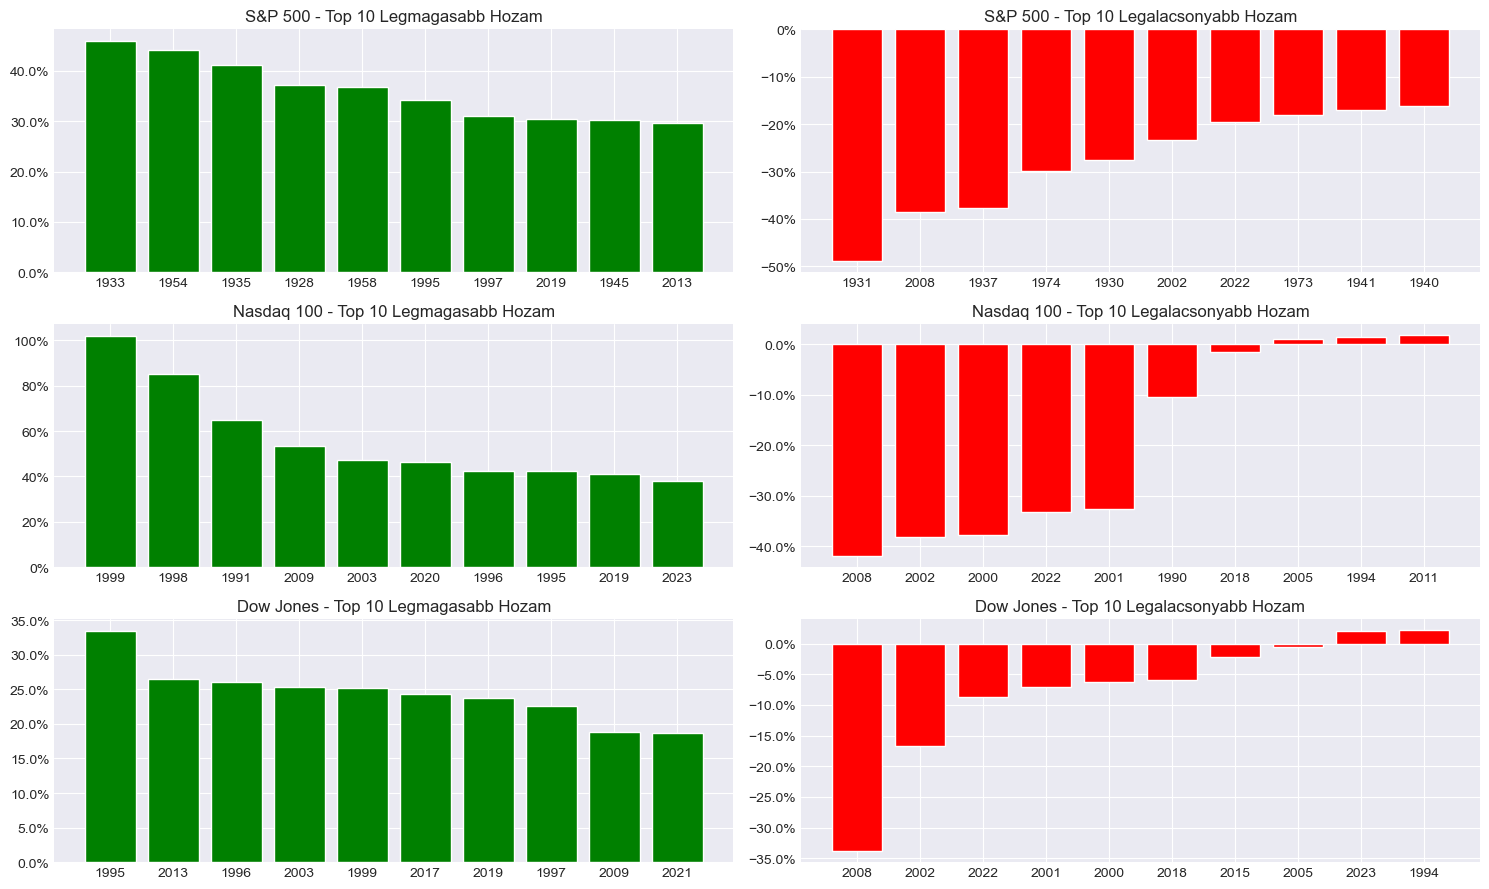

In [323]:
top_n = 10
yearly_return = {}

for name, idx in indeces.items():
    annual_return = {}
    for year, group in idx.groupby(idx.index.year):
        open_price = group.iloc[0]['Open'] if group.iloc[0]['Open'] != 0 else group.iloc[0]['Close']
        close_price = group.iloc[-1]['Close']

        if pd.notna(open_price) and pd.notna(close_price):
            annual_return[year] = (close_price - open_price) / open_price

    yearly_return[name] = pd.Series(annual_return).dropna()

fig, axs = plt.subplots(3, 2, figsize=(15, 9))

if len(yearly_return) == 1:
    axs = [axs]

for i, (idx_name, returns) in enumerate(yearly_return.items()):
    top_highest = returns.nlargest(top_n).sort_values(ascending=False)
    top_lowest = returns.nsmallest(top_n).sort_values(ascending=True)

    # Legjobbak
    ax_high = axs[i][0]
    ax_high.bar(top_highest.index.astype(str), top_highest.values, color='green')
    ax_high.set_title(f"{idx_name} - Top {top_n} Legmagasabb Hozam")
    ax_high.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Legrosszabbak
    ax_low = axs[i][1]
    ax_low.bar(top_lowest.index.astype(str), top_lowest.values, color='red')
    ax_low.set_title(f"{idx_name} - Top {top_n} Legalacsonyabb Hozam")
    ax_low.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()

Az ábrán látható, hogy a Nasdaq 100 a legvolatilisebb (100% feletti csúcs és sűrűbb -30% alatti évek), míg a Dow Jones a legstabilabb index. A legrosszabb évek listáján több pozitív hozamú év is szerepel, ami jelzi, hogy a tőzsdén a növekedés az uralkodó irány. A grafikonokon jól láthatóak a történelmi válságok (világválság, dotcom crash, 2008-as gazdasági válság) egységesen negatív hatásai.

## Inflációs adatok eloszlása

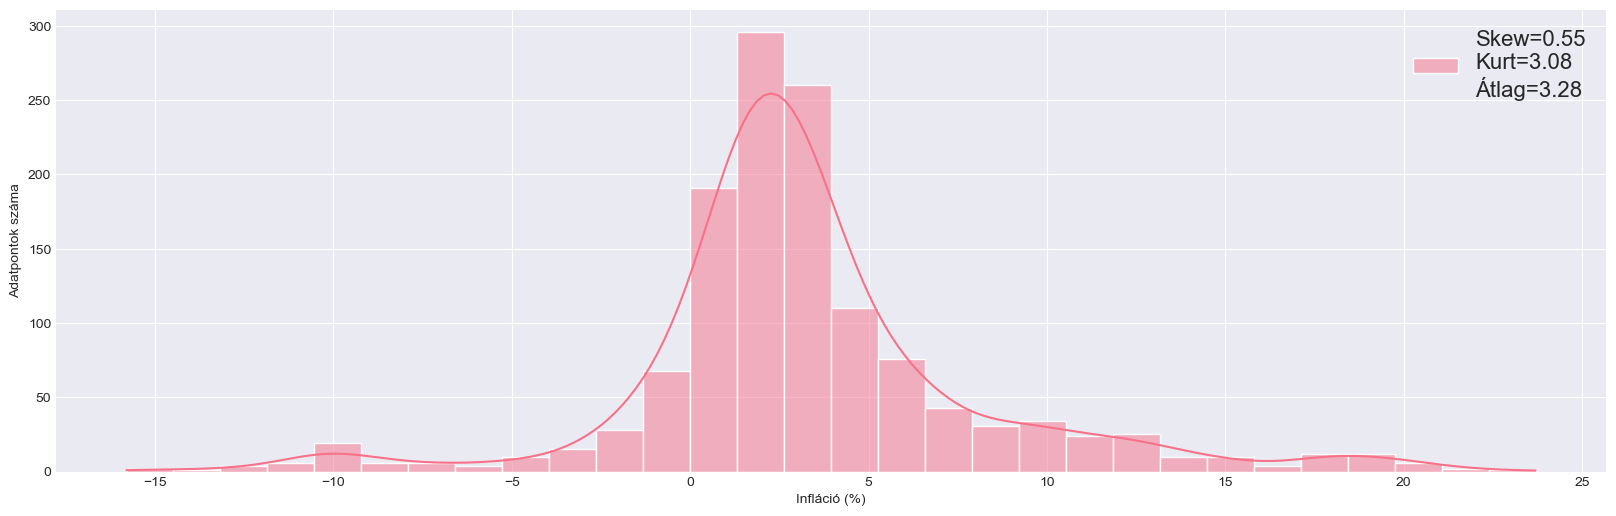

In [302]:
skew = inflation['Inflation'].skew()
kurt = inflation['Inflation'].kurtosis()
mean = inflation['Inflation'].mean()

plt.figure(figsize=(20,6))
sns.histplot(inflation['Inflation'], bins=30, kde=True, label=f'Skew={skew:.2f}\nKurt={kurt:.2f}\nÁtlag={mean:.2f}')
plt.xlabel("Infláció (%)")
plt.ylabel("Adatpontok száma")
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

Ferdeség: 0.55 : A pozitív ferdeség azt jelenti, hogy az eloszlás enyhén jobbra húzódik, azaz a leggyakoribb inflációs értékek a medián alatt helyezkednek el, és az eloszlásnak van egy hosszabb "farka" a magas infláció irányába, tehát a ritkán előforduló, extrém magas inflációs sokkok valószínűbbek voltak, mint az extrém deflációs sokkok.

Csúcsosság: 3.08 :  A 3.08 érték azt jelenti, hogy az eloszlás nagyon közel áll a normál eloszláshoz. Az enyhén 3 feletti érték azt jelzi, hogy az infláció a középpontban enyhén csúcsosabb, és a szélső értékek is enyhén gyakoribbak, mint amit a normál eloszlás feltételezne.

# Hipotézisek

## Az indexek (és részvények) hozama nem autokorrelál

Amióta érdekel ez a téma, a kereskedési stratégiákról gyakran olyan kontextusban olvasok, ahol az egyik kulcsmondat az, hogy *"past performance is not indicative of future results"*. Tehát ha egy stratégia backtest-en rendkívüli hozamot tud elérni, az nem garantálja, hogy ez a jövőben is így lesz.
Statisztikai értelemben ez azt jelenti, hogy a hozamok időben nem mutatnak autokorrelációt:  a mai hozam nem függ a tegnapi vagy korábbi hozamoktól.
A következő grafikon ezt a hipotézist vizsgálja, és azt próbálja igazolni, hogy a hozamok „emlékezet nélküliek”.


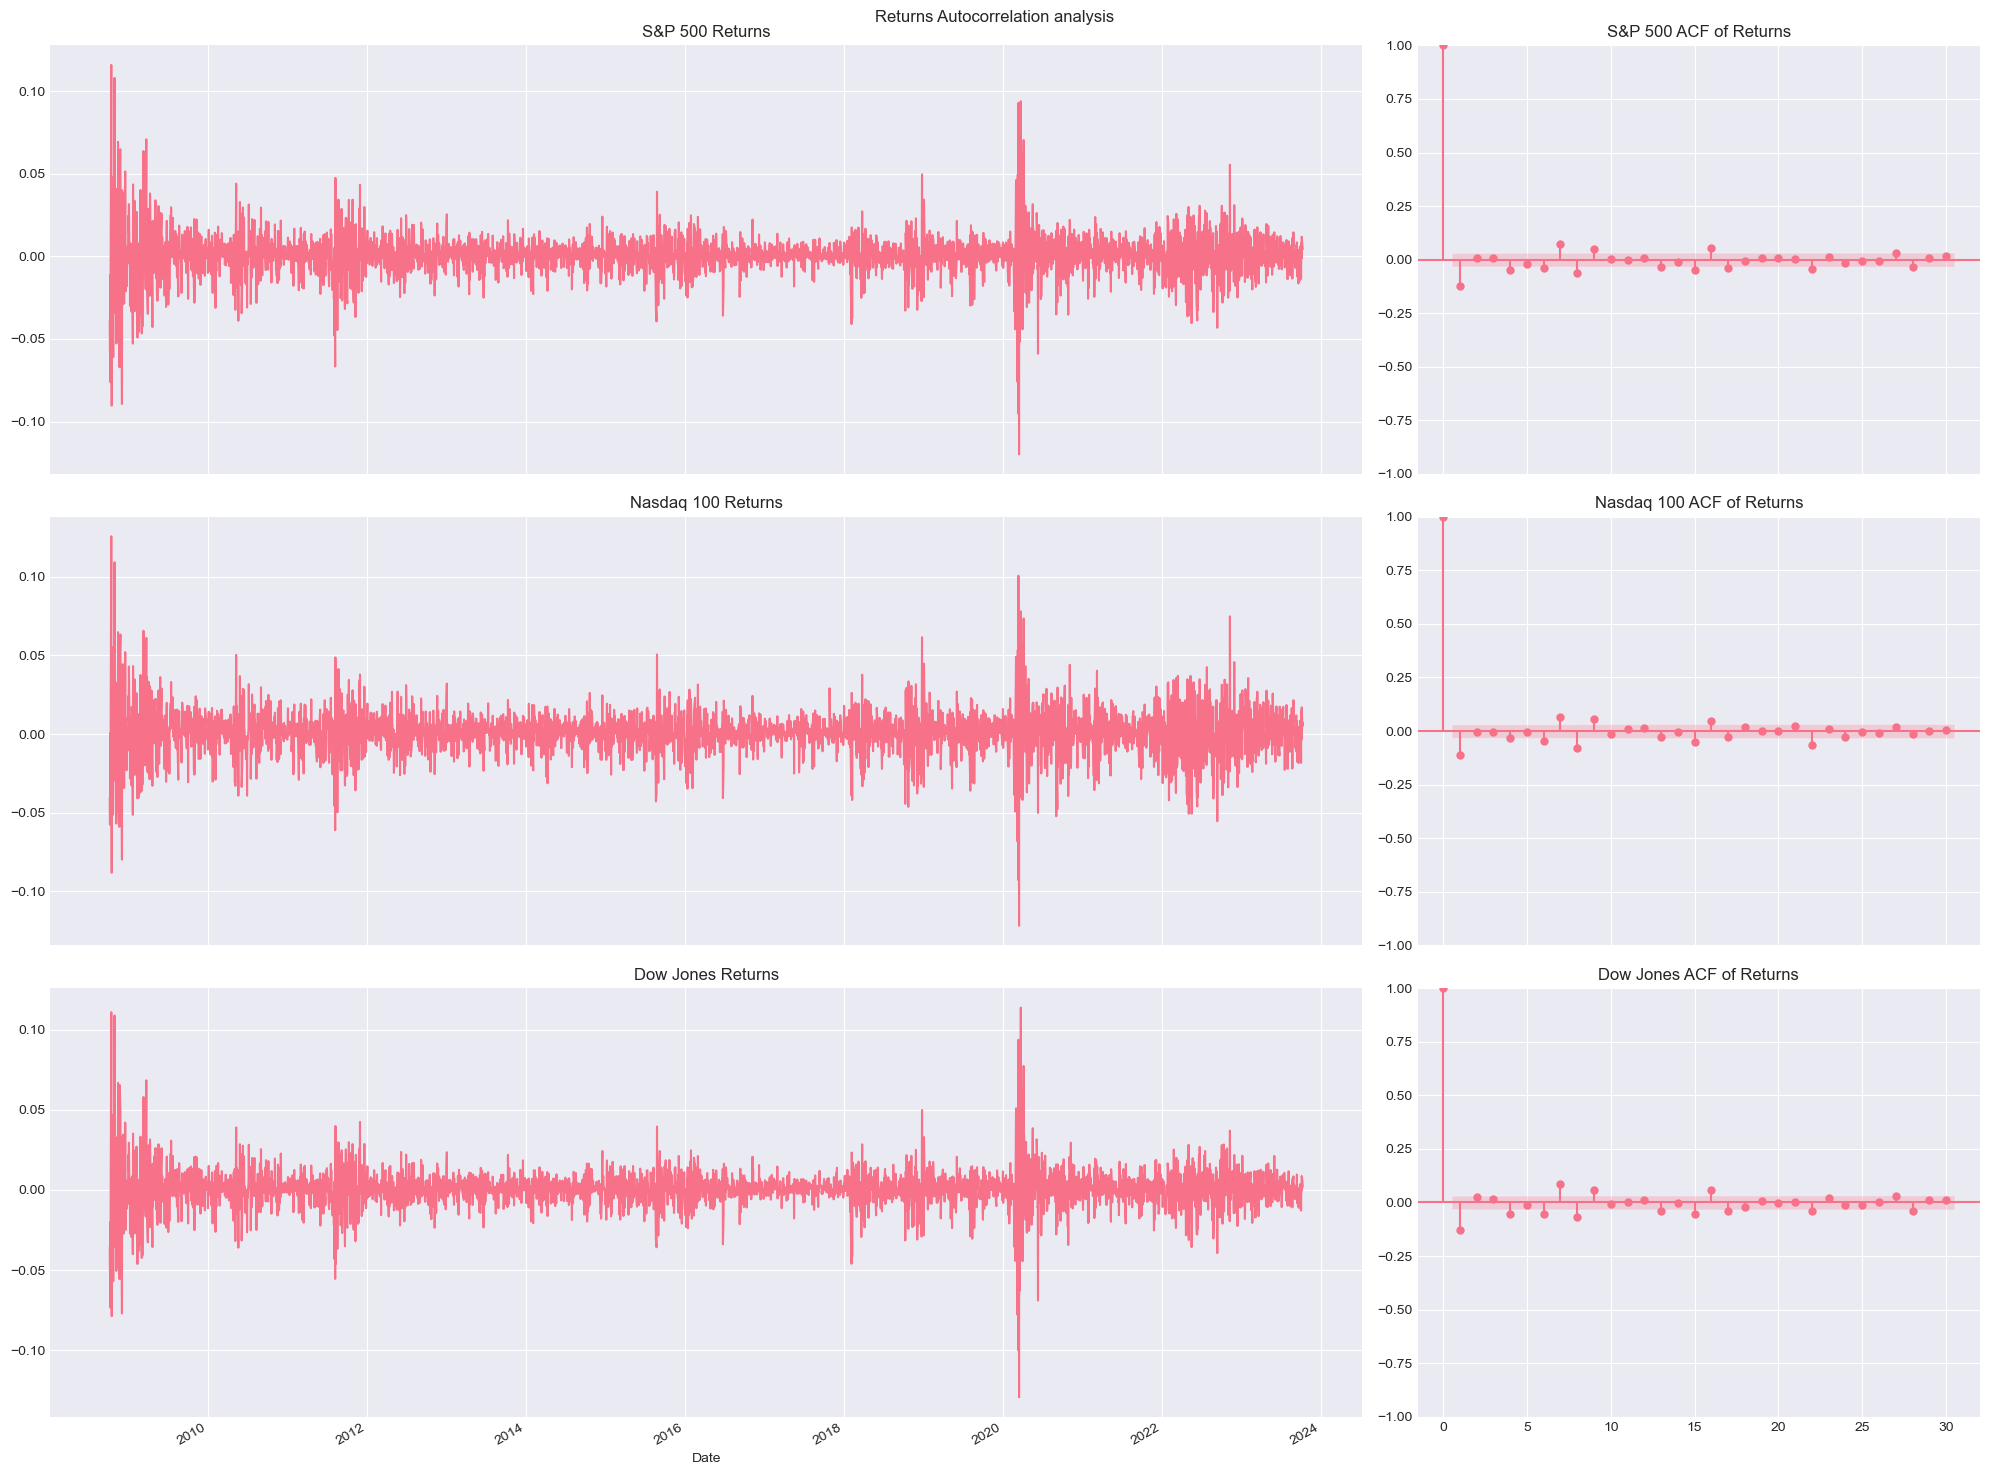

In [303]:
lookback_days = 252*15

fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
fig.suptitle("Returns Autocorrelation analysis")

for i, (name, idx) in enumerate(indeces.items()):
    idx['Return'].iloc[-lookback_days:].plot(ax=axs[i,0])
    axs[i,0].set_title(f"{name} Returns")

    plot_acf(idx['Return'].iloc[-lookback_days:].dropna(), lags=30, ax=axs[i,1])
    axs[i,1].set_title(f"{name} ACF of Returns")

plt.tight_layout()
plt.show()

A bal oldali ábra az idősor tényleges, százalékos hozamait mutatja, időben egymás után.
Ez alapján látható, hogy a hozamok ingadoznak, de vizuálisan nem látszik tartós trend vagy ismétlődő mintázat.

A jobb oldali ábra ugyanezen hozamok ACF-je.
Ha a hozamok nem autokorrelálnak, akkor az ACF értékei a nulla körül szóródnak, és egyik késleltetésnél sincs szignifikáns kiugrás.
Ez azt jelenti, hogy a múltbeli hozamok nem hordoznak előrejelző erőt a jövőbeli hozamokra, vagyis az idősor „emlékezet nélküli”.

Ez teljesen logikus, hiszen ha lenne bármilyen ismert összefüggés, annak hatása már rásze lenne a jelenlegi árnak, ezzel kioltva hasznosságát.

## Az indexek (és részvények) volatilitása autokorrelál

A hozammal ellentétben a volatilitás nem határoz meg irányt, tehát nem lehet része az árnak (legalábbis részvények esetén; más pénzpiaci termékeknél lehet közvetlen hatása). Feltevésem, hogy magasabb volatilitású időszakot jellemzően további magas volatilitású időszak követi.


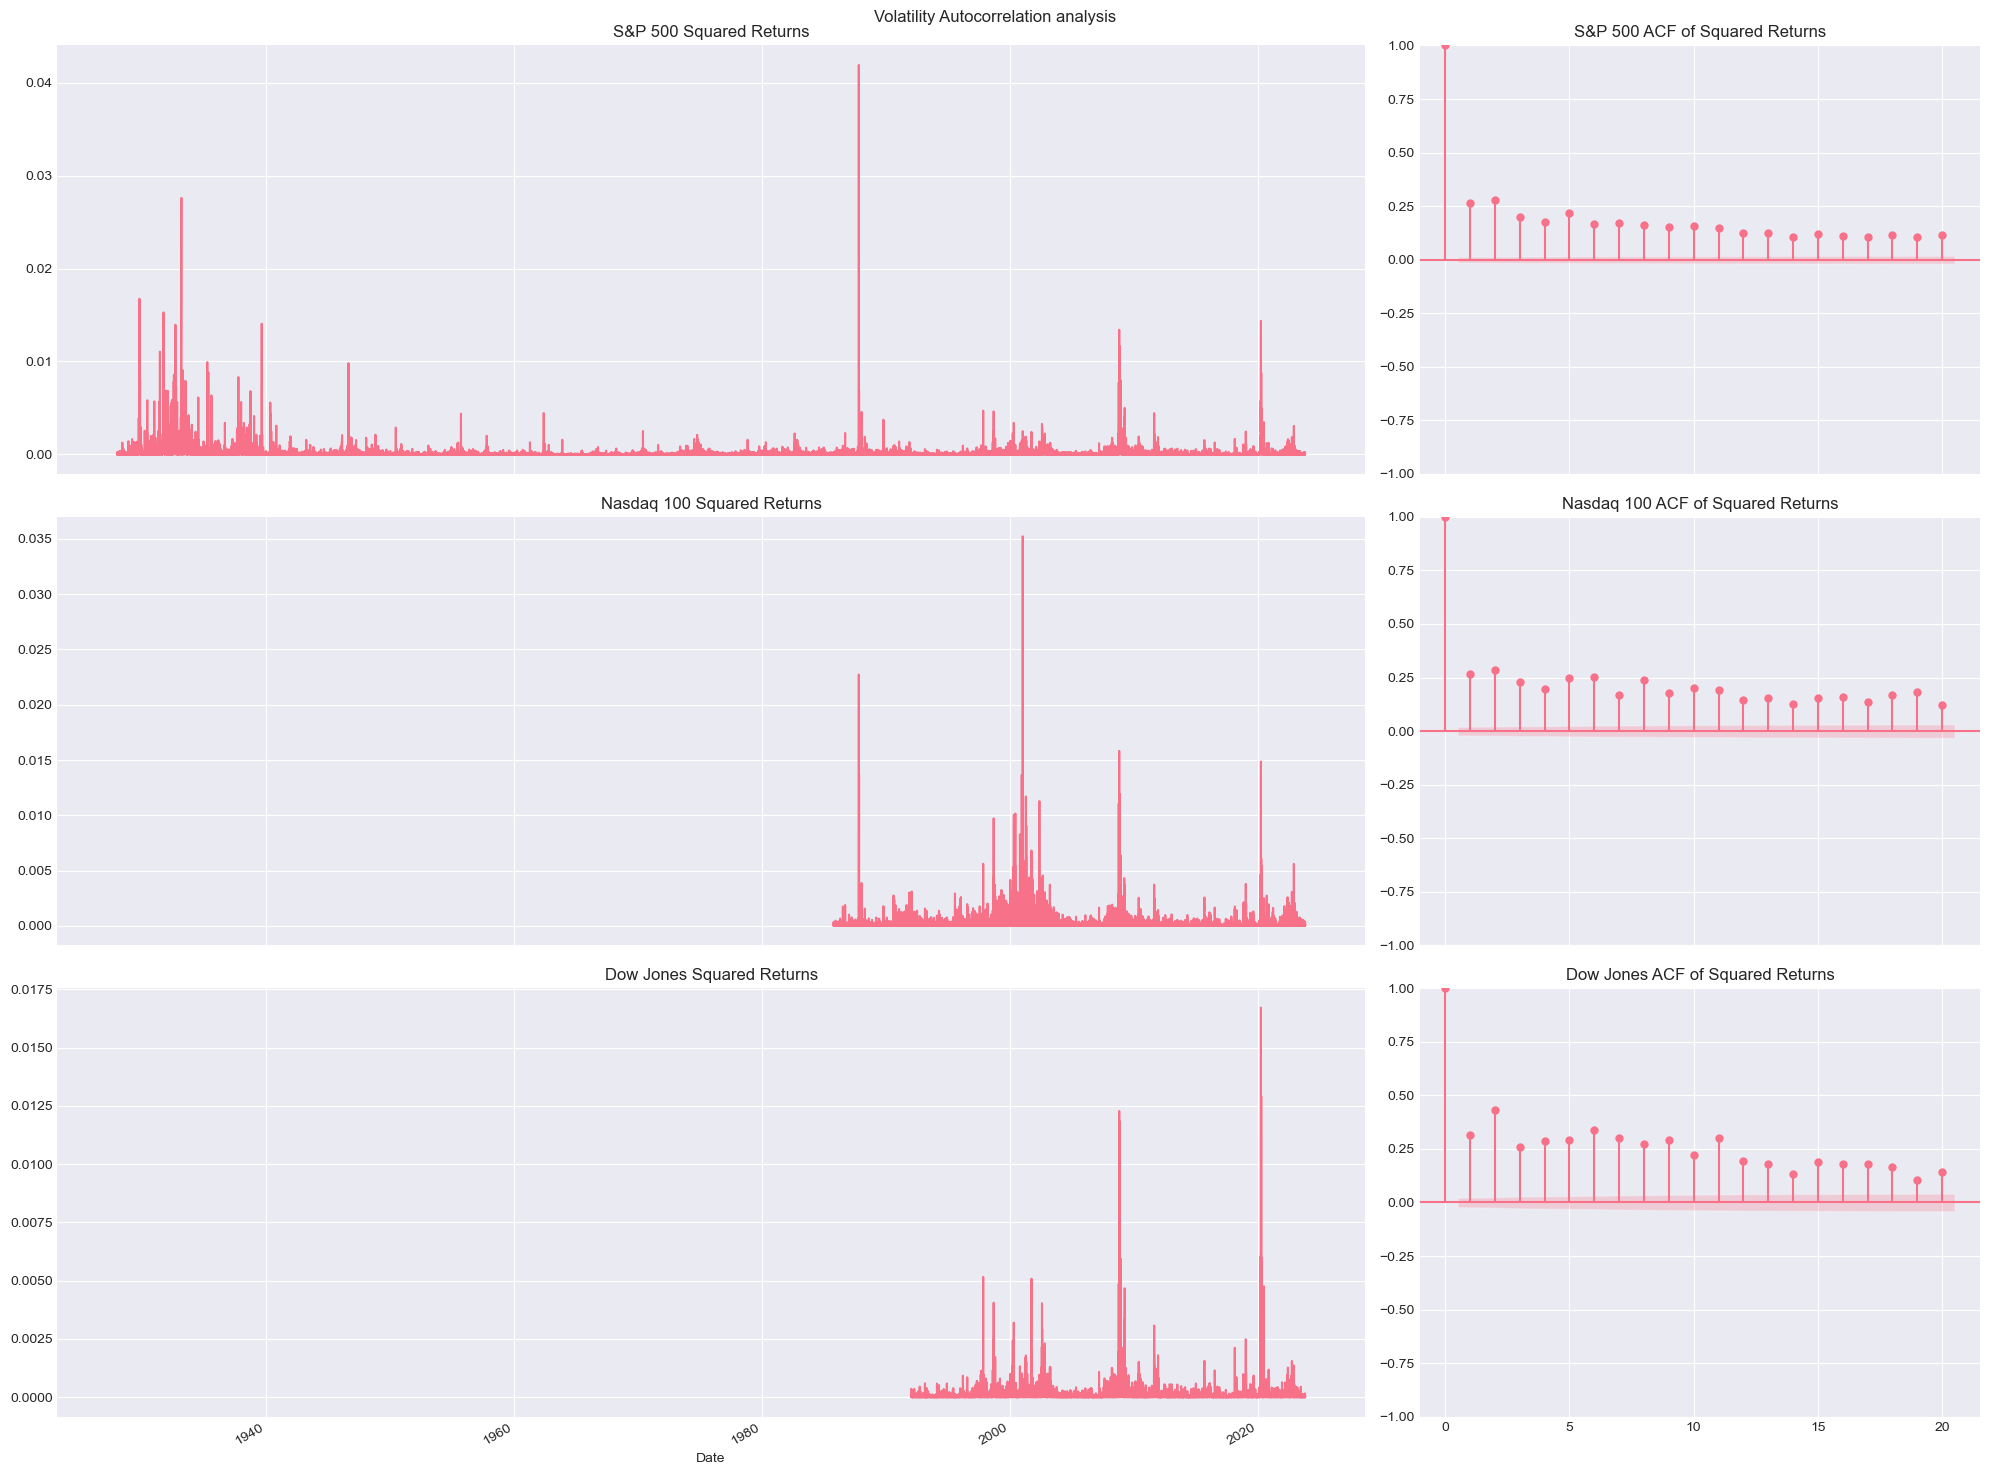

In [304]:
test_results = {}
acf_lag = 20

fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
fig.suptitle("Volatility Autocorrelation analysis")

for i, (name, idx) in enumerate(indeces.items()):
    idx["Squared return"]=idx['Return']**2
    idx["Squared return"].plot(ax=axs[i,0])
    axs[i,0].set_title(f"{name} Squared Returns")

    plot_acf(idx["Squared return"].dropna(), lags=acf_lag, ax=axs[i,1])
    axs[i,1].set_title(f"{name} ACF of Squared Returns")

plt.tight_layout()
plt.show()


Már a négyzetes hozam grafikonján is megfigyelhetőek hullámok kiugró értékek körül, tehát nem túl meglepő, amikor az ACF-en is láthatóak jelentős értékek, még huszas lag mellett is.

Ezt a jelenséget szaknyelven *volatility clustering*-nek is szokták hívni

## Az inflációs kötnyezet hatása szektoronként

Amikor inflációról beszélünk, gyakran hajlamosak vagyunk egyetlen, mindent elsöprő mutatóként tekinteni rá, amely egységesen befolyásolja a gazdaságot. Azonban a piaci folyamatokat közelebbről vizsgálva hamar világossá válik, hogy az infláció változása nem egyformán érinti a szereplőket. Személyes kiváncsiságom folyamán többször is belefutottam bizonyos útmutatókba, melyek magas inflációs környezetben hivatottak befektetési tanácsokat adni. Ez által motiválva meg fogom vizsgálni, hogy milyen különbségek lépnek fel bizonyos szektorok közt különböző inflációs környezetben.


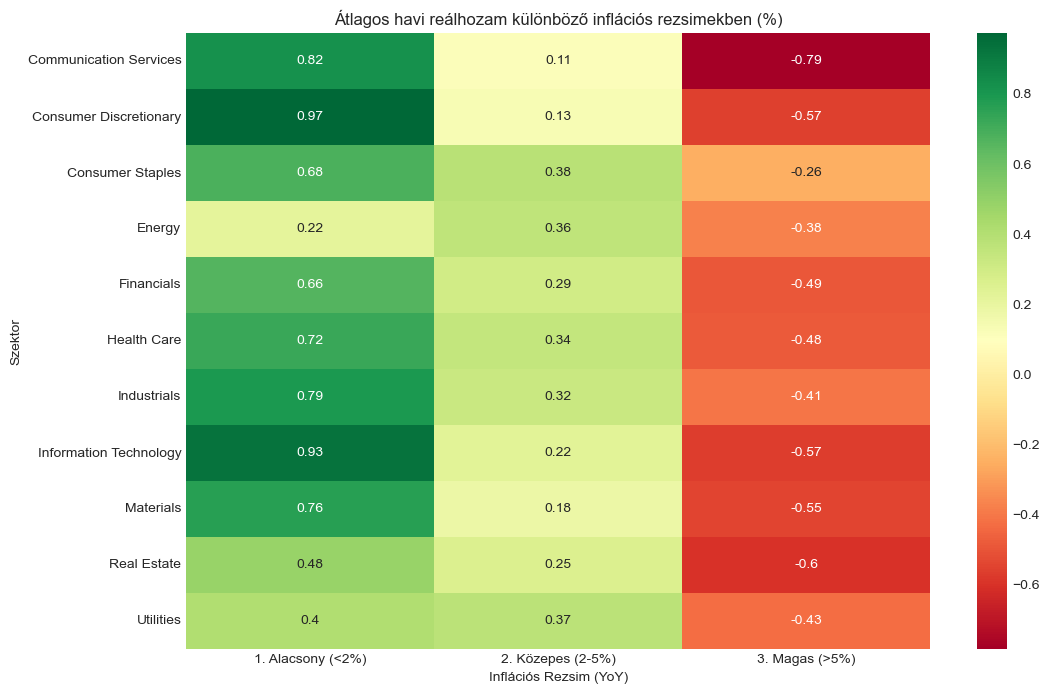

In [305]:
sector_map = pd.concat([
    sp500_companies[['Symbol', 'Sector']],
    dowjones_companies[['Symbol', 'Sector']],
    nasdaq100_companies[['Symbol', 'Sector']]
]).drop_duplicates(subset=['Symbol']).set_index('Symbol')['Sector']

## sum, mert log-hozamokat vizsgálunk, és azok időben additívak
monthly_returns = returns_stocks.resample('M').sum()
sector_perf = monthly_returns.groupby(sector_map, axis=1).mean()


inflation["Inflation MoM"] = (1 + (inflation["Inflation"] / 100))**(1/12) - 1
inflation["Inflation YoY"] = inflation["Inflation"] / 100
inflation.index = pd.to_datetime(inflation.index) + pd.offsets.MonthEnd(0)

combined_df = sector_perf.join(inflation[["Inflation YoY", "Inflation MoM"]], how='inner')

def get_inflation_regime(rate):
    if rate <= 0.02:
        return '1. Alacsony (<2%)'
    elif rate <= 0.05:
        return '2. Közepes (2-5%)'
    else:
        return '3. Magas (>5%)'

combined_df['Regime'] = combined_df['Inflation YoY'].apply(get_inflation_regime)

# reálhozamok kiszámítása minden szektorra
for sector in sector_perf.columns:
    combined_df[f'{sector}_Real'] = (
        combined_df[sector] - np.log(1 + combined_df['Inflation MoM'])
    )

# aggregálás rezsimek szerint
real_cols = [c for c in combined_df.columns if '_Real' in c]
regime_analysis = combined_df.groupby('Regime')[real_cols].mean()
# levágjuk a '_Real' utótagot
regime_analysis.columns = [c.replace('_Real', '') for c in regime_analysis.columns]

#visszakonvertálás logaritmusból
regime_analysis_percent = np.exp(regime_analysis) - 1

# Százalékos formátumra hozzuk az értékeket a heatmap-en
plt.figure(figsize=(12, 8))
sns.heatmap(regime_analysis_percent.T * 100, annot=True, cmap='RdYlGn')

plt.title('Átlagos havi reálhozam különböző inflációs rezsimekben (%)')
plt.xlabel('Inflációs Rezsim (YoY)')
plt.ylabel('Szektor')
plt.show()

A hőtérkép világosan mutatja, hogy az infláció mértéke alapjaiban határozza meg a befektetések vásárlóerejét:

 - Alacsony infláció (<2%): Ebben a környezetben minden szektor pozitív reálhozamot biztosított. Különösen a Consumer Discretionary (0,97%) és az Information Technology (0,93%) profitált az alacsony inflációs környezetből. Ebben a környezetben a növekedési fókuszú vállalatok profitálnak a leginkább az alacsony diszkontrátákból. Az Energy szektor reálhozama itt a legalacsonyabb, ami érthető, mivel az alacsony infláció gyakran alacsonyabb energiaárakkal párosul.
 - Közepes infláció (2-5%): Ebben a tartományban a piaci dinamika megváltozik, a növekedési szektorok lassulnak, míg a defenzív és ciklikus ágazatok relatív ereje megnő. Míg a technológiai, és nyersanyag szektor hozama jelentősen lassul, a defenzív szektorok, mint a Consumer Staples és a Utilities, megőrizték stabilitásukat, mivel ezek a szektorok képesek a leginkább áthárítani a  költségnövekedést a fogyasztókra. Ez többek közt magyarázható azzal, hogy bármilyen gazdasági helyzetben van, áram, víz, étel és hasonló dolgokra mindig szüksége lesz az embereknek.
 - Magas infláció (>5%): Ebben a rezsimben nincs olyan szektor, amely átlagosan pozitív reálhozamot tudna felmutatni. Ez a legkritikusabb szakasz, ahol minden szektor átlagos havi reálhozama negatívba fordult. A legnagyobb reálérték-vesztést a Communication Services (-0,79%) és a Real Estate (-0,60%) szenvedte el, az utóbbi esetben az ilyen környezetre jellemző magas kamatok a legfőbb befolyásoló tényező. Bár a hozamuk negatív, a Consumer Staples és az Energy a "legkisebb rossznak". Ezek a szektorok nyújtják a legjobb védelmet a vásárlóerő radikális romlása ellen, a korábban is releváns okok miatt.

A korábban általam gyakran hallott tanácsokaz végre adatokkal alátámasztva is sikerúlt igazolnom. Míg 2% alatt a kockázatos eszközök dominálnak, 5% felett a teljes részvénypiac reálérték-vesztést szenved el, és csak a defenzív/reáleszköz alapú szektorok képesek mérsékelni a veszteségeket. Mellesleg, ilyen esetben a legkevésbé kockázatos, és a grafikon alapján is legkifizetődőbb dolog kötvényeket vásárolni, melyek néhány esetben az infláció mértékével is számolnak.


## After hours - Normal hours hozam vizsgálata

A modern részvénypiacok egyik legérdekesebb kettőssége a kereskedési időszakok szerkezetéből adódik. Miközben a grafikonokon gyakran egy folytonos vonalat látunk, a valóságban két élesen elkülöníthető szakasz váltja egymást: a napközbeni kereskedés (Intraday / Normal hours) és a zárástól nyitásig tartó időszak (Overnight / After hours). Ez a vizsgálat azt hivatott feltárni, hogy létezik-e szisztematikus eltérés a két periódus teljesítménye között.

 - Információs aszimmetria: A fontos vállalati jelentések, makrogazdasági adatok és váratlan politikai események gyakran a tőzsdezárás után látnak napvilágot. Ezek hatása a másnapi nyitóárban („gap”) árazódik be.
 - Likviditás és volatilitás: A hivatalos nyitvatartás alatt a nagy intézményi befektetők aktivitása és a magas likviditás dominál, míg az éjszakai szakaszban az alacsonyabb forgalom miatt a piac érzékenyebb lehet a sokkokra.
 - Anomáliák keresése: Számos kutatás (például az amerikai indexek esetén) arra mutatott rá, hogy a hosszú távú emelkedő trend jelentős része az éjszakai órákban realizálódik, míg a napközbeni szakasz gyakran oldalazást vagy korrekciót mutat.

A vizsgálat módszertana: A számítás során az alábbi két komponenst hasonlítjuk össze naponta:
 - Overnight hozam: A mai nyitóár és az előző napi záróár különbsége.
 - Intraday hozam: A mai záróár és a mai nyitóár különbsége.

A célunk annak meghatározása, hogy a választott indexeknél a napközbeni és az éjszakai hozam különbsége milyen eloszlást mutat az elmúlt 40 év távlatában.


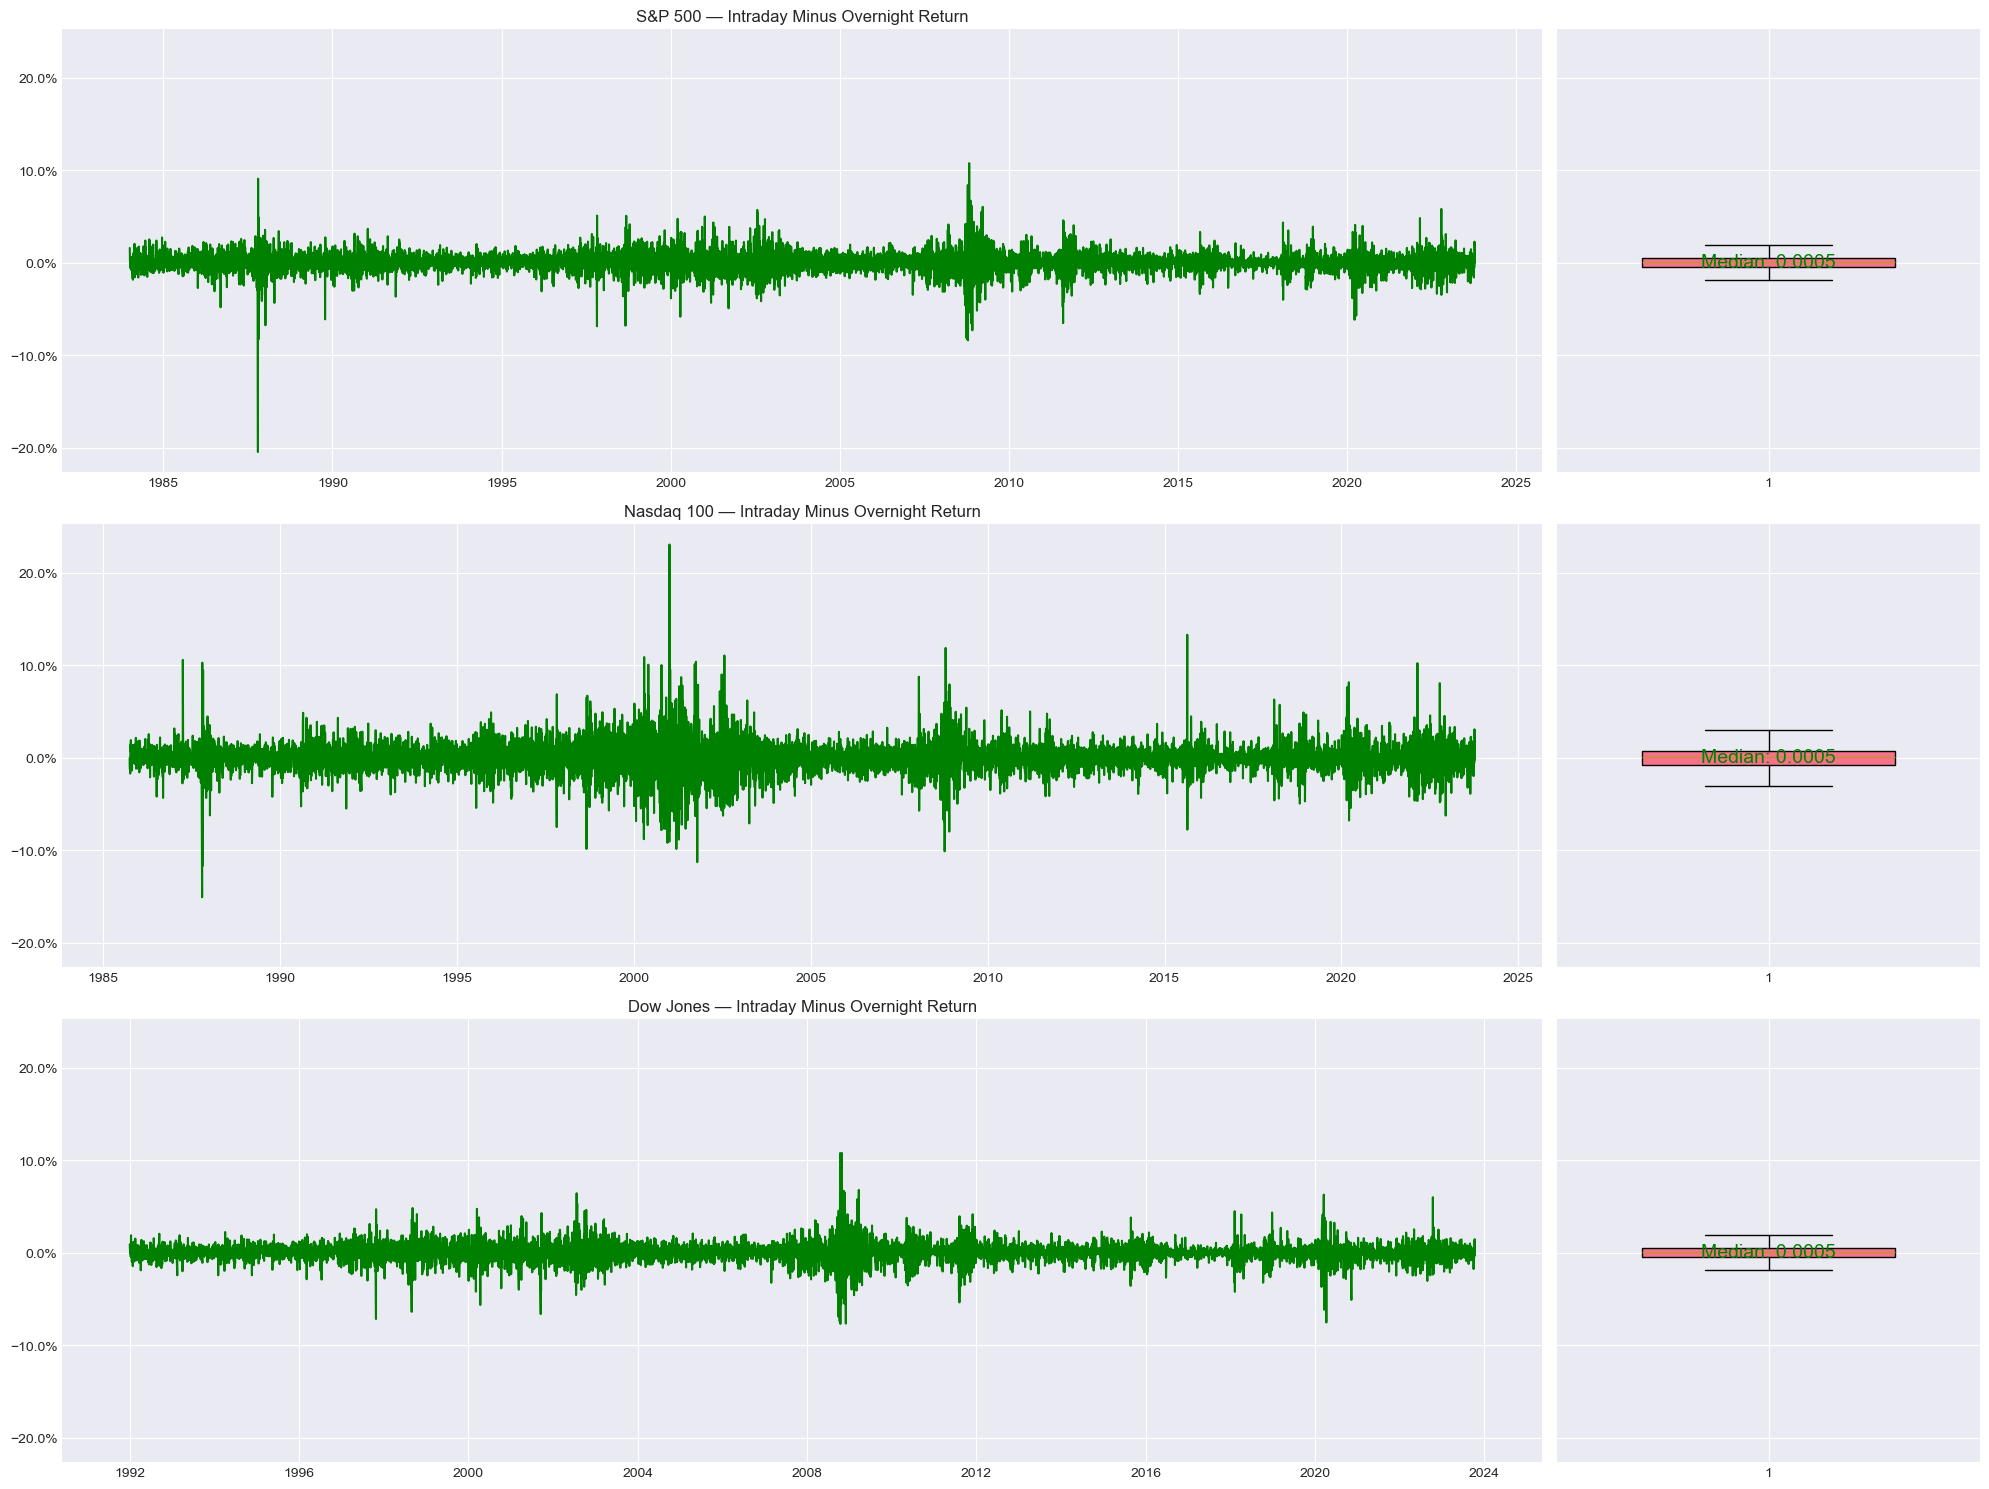

In [333]:
lookback_years = 40

return_diff = {}

for name, idx in indeces.items():
    df = idx.sort_index().copy()

    # lookback_years-re korlátoz
    all_years = df.index.year.unique()
    last_years = all_years[-lookback_years:] if len(all_years) >= lookback_years else all_years
    df = df[df.index.year.isin(last_years)]

    df['PrevClose'] = df['Close'].shift(1)

    # 0-ás open price esetén
    df['Open_fixed'] = df['Open']
    mask_zero = df['Open_fixed'] == 0
    df.loc[mask_zero, 'Open_fixed'] = df.loc[mask_zero, 'PrevClose']

    df = df.dropna(subset=['Open_fixed', 'PrevClose', 'Close'])
    df = df[df['Open_fixed'] != 0]

    df['OvernightReturn'] = (df['Open_fixed'] - df['PrevClose']) / df['PrevClose']
    df['IntradayReturn'] = (df['Close'] - df['Open_fixed']) / df['Open_fixed']

    return_diff[name] =  df['IntradayReturn'] - df['OvernightReturn']

fig, axs = plt.subplots(len(indeces), 2, figsize=(20,15), sharex=False, sharey=True, gridspec_kw={'width_ratios': [7, 2]})

for i, name in enumerate(indeces.keys()):
    ax_line = axs[i,0] if len(indeces) > 1 else axs[0]

    ax_line.plot(return_diff[name].index, return_diff[name], color='green')
    ax_line.set_title(f"{name} — Intraday Minus Overnight Return")
    ax_line.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    ax_box = axs[i,1] if len(indeces) > 1 else axs[1]

    ax_box.boxplot(return_diff[name].values, patch_artist=True, widths=0.6, showfliers=False)
    median_val = return_diff[name].median()
    ax_box.text(1, median_val, f"Median: {median_val:.4f}", color='green', va='center', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

A boxplotok mediánja mindkét index esetében rendkívül közel van a 0-hoz. Ez arra utal, hogy a vizsgált teljes időszak átlagában a két session-nek nincs tartós előnye egymással szemben.

A vonaldiagramok azt mutatják, hogy a legnagyobb pozitív vagy negatív kiugrások a piaci stressz idején (pl. 2008-as válság) jelentek meg. Ez azt jelzi, hogy a válságok alatt információs egyensúlyhiány lép fel, és egy nagy, sokk alapú Overnight mozgást gyakran egy ellentétes, pánik alapú Intraday mozgás követ.

## Év hónapjainak átlagos hozama, volatilitása

A témával való ismerkedésem és beszélgetések folyamán gyakran hallottam, hogy a nyár végi - őszi hónapok a legrosszabbak részvények teljesítményére tekintettel.
Ebben a felyezetben ezt a feltevést fogom megvizsgálni, és kutatással okot találni az eredményre

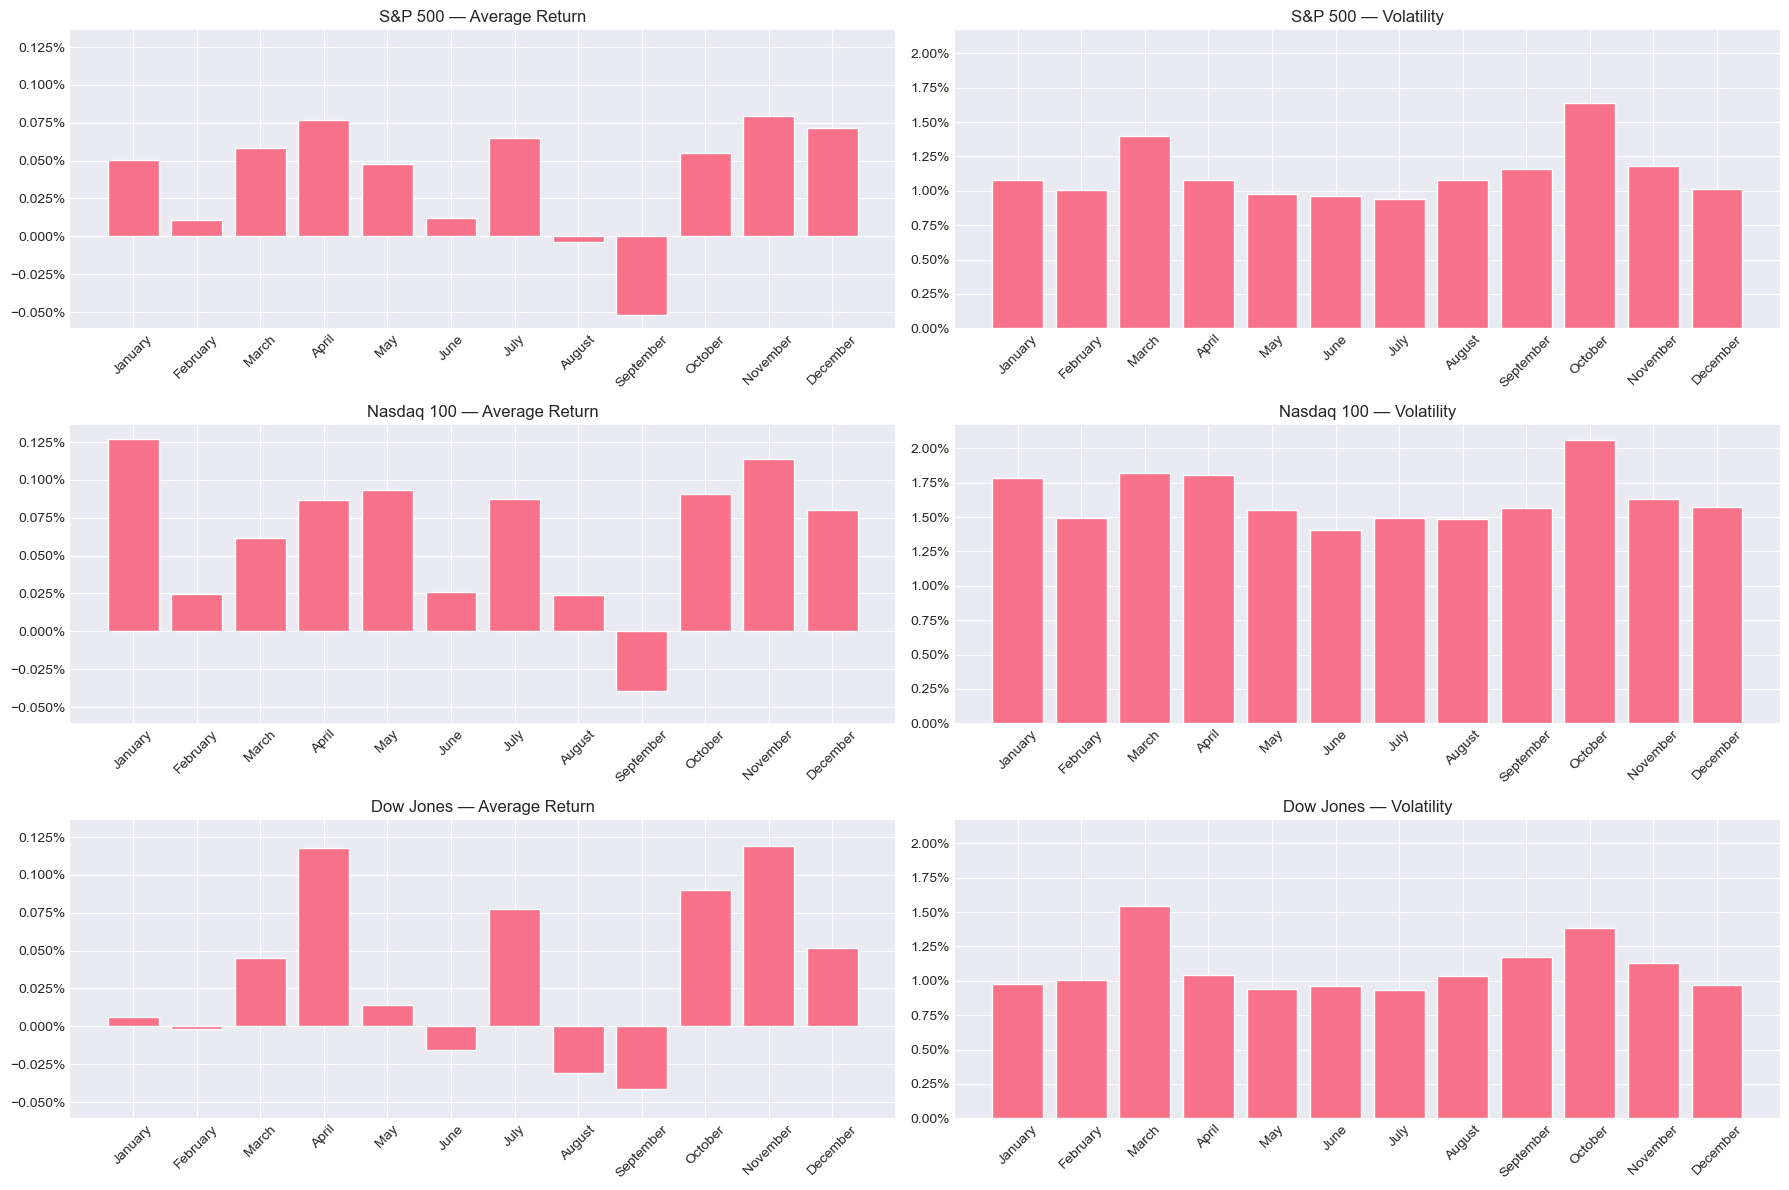

In [334]:
x = 40

month_avg = {}
month_vol = {}
month_volume = {}

for name, idx in indeces.items():
    # Évek meghatározása
    all_years = idx.index.year.unique()
    last_years = all_years[-x:] if len(all_years) >= x else all_years

    idx_recent = idx[idx.index.year.isin(last_years)].copy()
    idx_recent['Month'] = idx_recent.index.month

    average = idx_recent.groupby('Month')['Return'].mean()
    volatility = idx_recent.groupby('Month')['Return'].std()

    # Szám-hónap hozzárendelés
    average.index = average.index.map(lambda m: calendar.month_name[m])
    volatility.index = volatility.index.map(lambda m: calendar.month_name[m])

    month_avg[name] = average
    month_vol[name] = volatility

index_names = list(month_avg.keys())
months = month_avg[index_names[0]].index

fig, axs = plt.subplots(3, 2, figsize=(18, 12), sharey='col')

metrics = [
    ("Average Return", month_avg),
    ("Volatility", month_vol)
]

for i, idx_name in enumerate(index_names):
    for j, (metric_name, metric_dict) in enumerate(metrics):
        ax = axs[i, j]
        values = metric_dict[idx_name].values

        ax.bar(months, values)
        ax.set_title(f"{idx_name} — {metric_name}")
        ax.set_xticklabels(months, rotation=45)
        ax.grid(True, axis='y')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()


A hozamok láthatóan erősek januárban, év végi adóoptimalizálás miatt, új pénz beáramlása miatt, és alapok viselkedése miatt. Ezután lecsillapodik a következő hónapokban. Április szintén az erősebb hónapokhoz tartozik Q1-es jelentések, USA-ban adóhónap miatt is. Nyár általában gyengébb illikviditás, makro narratívák hiánya, és általános "üresjárat miatt". Szeptember a legrosszabb hónap alapok viselkedése, makro kockázatok miatt. Ezután erősebb időszak következik, részben a korábbi gyenge hónapok miatti 'leárazott' részvényeket vásárló piaci résztvevők miatt.
Összesítve ez a ciklikusság adóoptimalizálás, negyedéves adatok, likviditási időszakok, intézményi viselkedési minták, és makrogazdasági ciklusok kombinációjával magyarázható.

A volatilitás tavasszal és ősszel magasabb, ami a makroadatok, és korábbi gyenge piac kihasználásával magyarázható

## Korreláció szerinti csoportosítással részvények szektorokra bontása

A részvények korábbi korrelációs vizsgálatánál megfigyeltem, hogy az általam ismert, nagyjából egy csoportba tartozó részvények hajlamosak magas korrelációt mutatni egymással, míg alacsony korreláció jellemzi az egymástól távol álló részvényeket. Ebben a részben ezeket tovább vizsgálom, és megpróbálom ezen korrelációs adatok alapján visszafejteni azt, hogy mely részvények tartoznak ugyanabba a szektorba.

### Legerősebb korrelációk

Először megjelenítem a legjobban korreláló részvényeket, és megvizsgálom, hogy a feltevésem alapján valóban gyakori-e, hogy a magas korrelációjú részvénypárok azonos szektorokban találhatóak.

n paraméterrel állítható, hogy mennyit szeretnénk megjeleníteni.

Amint az eredményen látható, nagyor erős bizonyítékunk van arra, hogy a korreláció jól jellemzi azt, hogy melyik cégek találhatóak azonos szektorokban.
Az esetek többségében a piaci korreláció nem 2 cég közötti viszonyt írja le, hanem kitettségük a piacra tekintettel mennyire egyezik meg, és mivel a szektorok kiettségei nagyvonalakban azonosak, ezért folytatom a vizsgálatot.

### Átlagos korreláció szektorokon belül

In [308]:
n = 500

corr_df = corr_matrix.stack().reset_index()
corr_df.columns = ['A', 'B', 'Correlation']

corr_df = corr_df[
    (corr_df['A'] != corr_df['B']) &
    (corr_df['A'] < corr_df['B'])
].sort_values(by='Correlation', ascending=False)

top_n = corr_df.head(n)

top_n['A Sector'] = top_n['A'].map(sector_map)
top_n['B Sector'] = top_n['B'].map(sector_map)

matching_count = (top_n['A Sector'] == top_n['B Sector']).sum()

print(f"A {n} legjobban korreláló részvényből {matching_count} db azonos szektorból származik.")


A 500 legjobban korreláló részvényből 471 db azonos szektorból származik.


Ebben a fejezetben megvizsgálom, hogy egy szektoron belül található részvények milyen átlagos korrelációt mutatnak egymással.

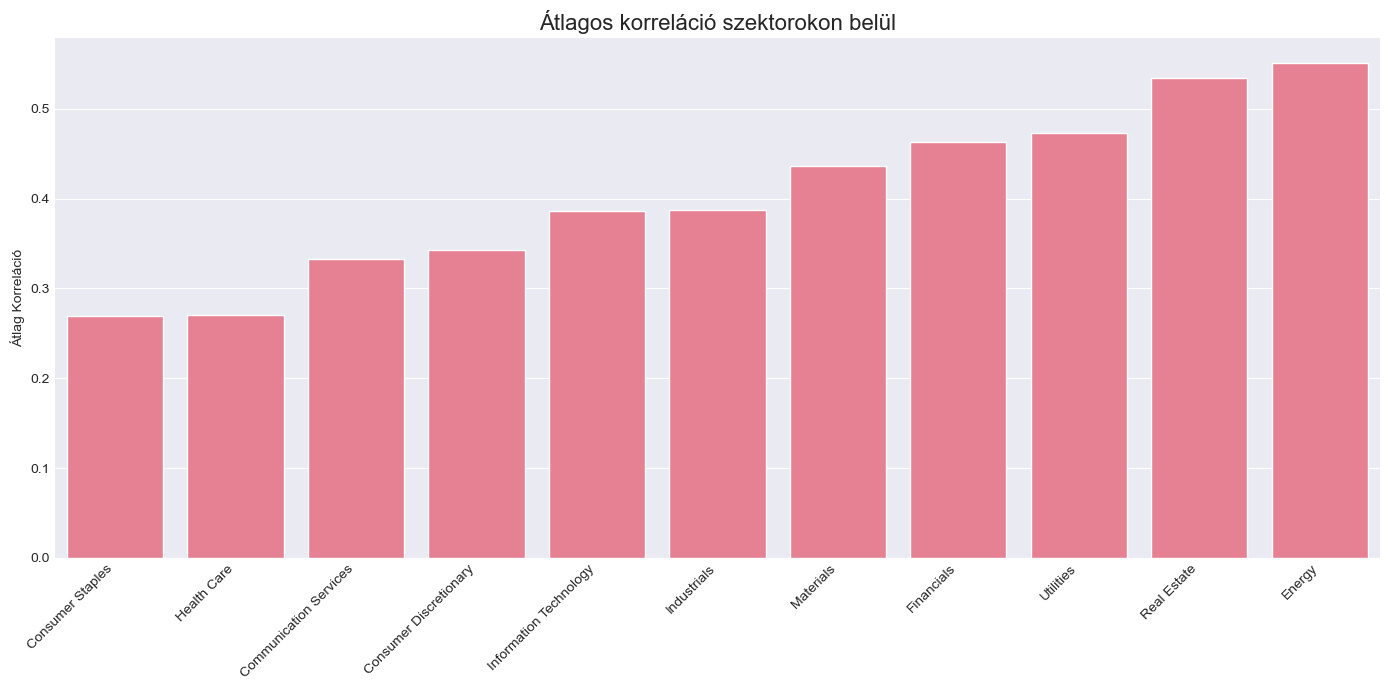

In [309]:
sector_groups = sector_map.reset_index().groupby('Sector')['Symbol'].apply(list)

sector_correlation_results = {}

for sector_name, symbols in sector_groups.items():
    valid_symbols = [s for s in symbols if s in returns_stocks.columns]

    corr_matrix_forpair = returns_stocks[valid_symbols].corr()
    pairwise_correlations = corr_matrix_forpair.values[np.triu_indices_from(corr_matrix_forpair, k=1)]
    sector_correlation_results[sector_name] = np.mean(pairwise_correlations)


avg_corr_series = pd.Series(sector_correlation_results).sort_values()

plt.figure(figsize=(14, 7))
ax = sns.barplot(avg_corr_series)

plt.title('Átlagos korreláció szektorokon belül', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Átlag Korreláció')
plt.tight_layout()
plt.show()

Látható, hogy a szektoron belüli korrelációk a szektorok többségére jóval a 0.30-as átlagkorreláció felett van, tehát a feltevésem szerint folytatható a vizsgálat.

 - A közmű és az energia szektorok mutatják a legmagasabb belső korrelációt, ami arra utal, hogy ezeket a részvényeket elsősorban egységes makrogazdasági tényezők, például nyersanyagárak vagy kamatkörnyezet mozgatják.
 - A Health Care és a Communication Services szektor alacsony korrelációja abból adódik, hogy a bennük működő vállalatok eltérő üzleti modellekre, szabályozási környezetre és gazdasági ciklusokra reagálnak, ezért árfolyamaik kevésbé mozognak együtt.
 - Átlagos piaci klaszterek: Az olyan középső szektorok, mint az Information Technology vagy a Financials, a piaci átlaghoz közeli együttmozgást mutatnak, ami kiegyensúlyozott arányt jelez a szektorhírek és az egyedi vállalati teljesítmények között.

### Szektorok közötti korreláció

Végül a szektorok közti korrelációt vizsgálom, mielőtt a klaszterezésre térek, ezzel felismerhetőek mely szektorokat lesz könnyű elkülöníteni, és melyeket keverhet össze nagyobb valószínűséggel a klaszterező.

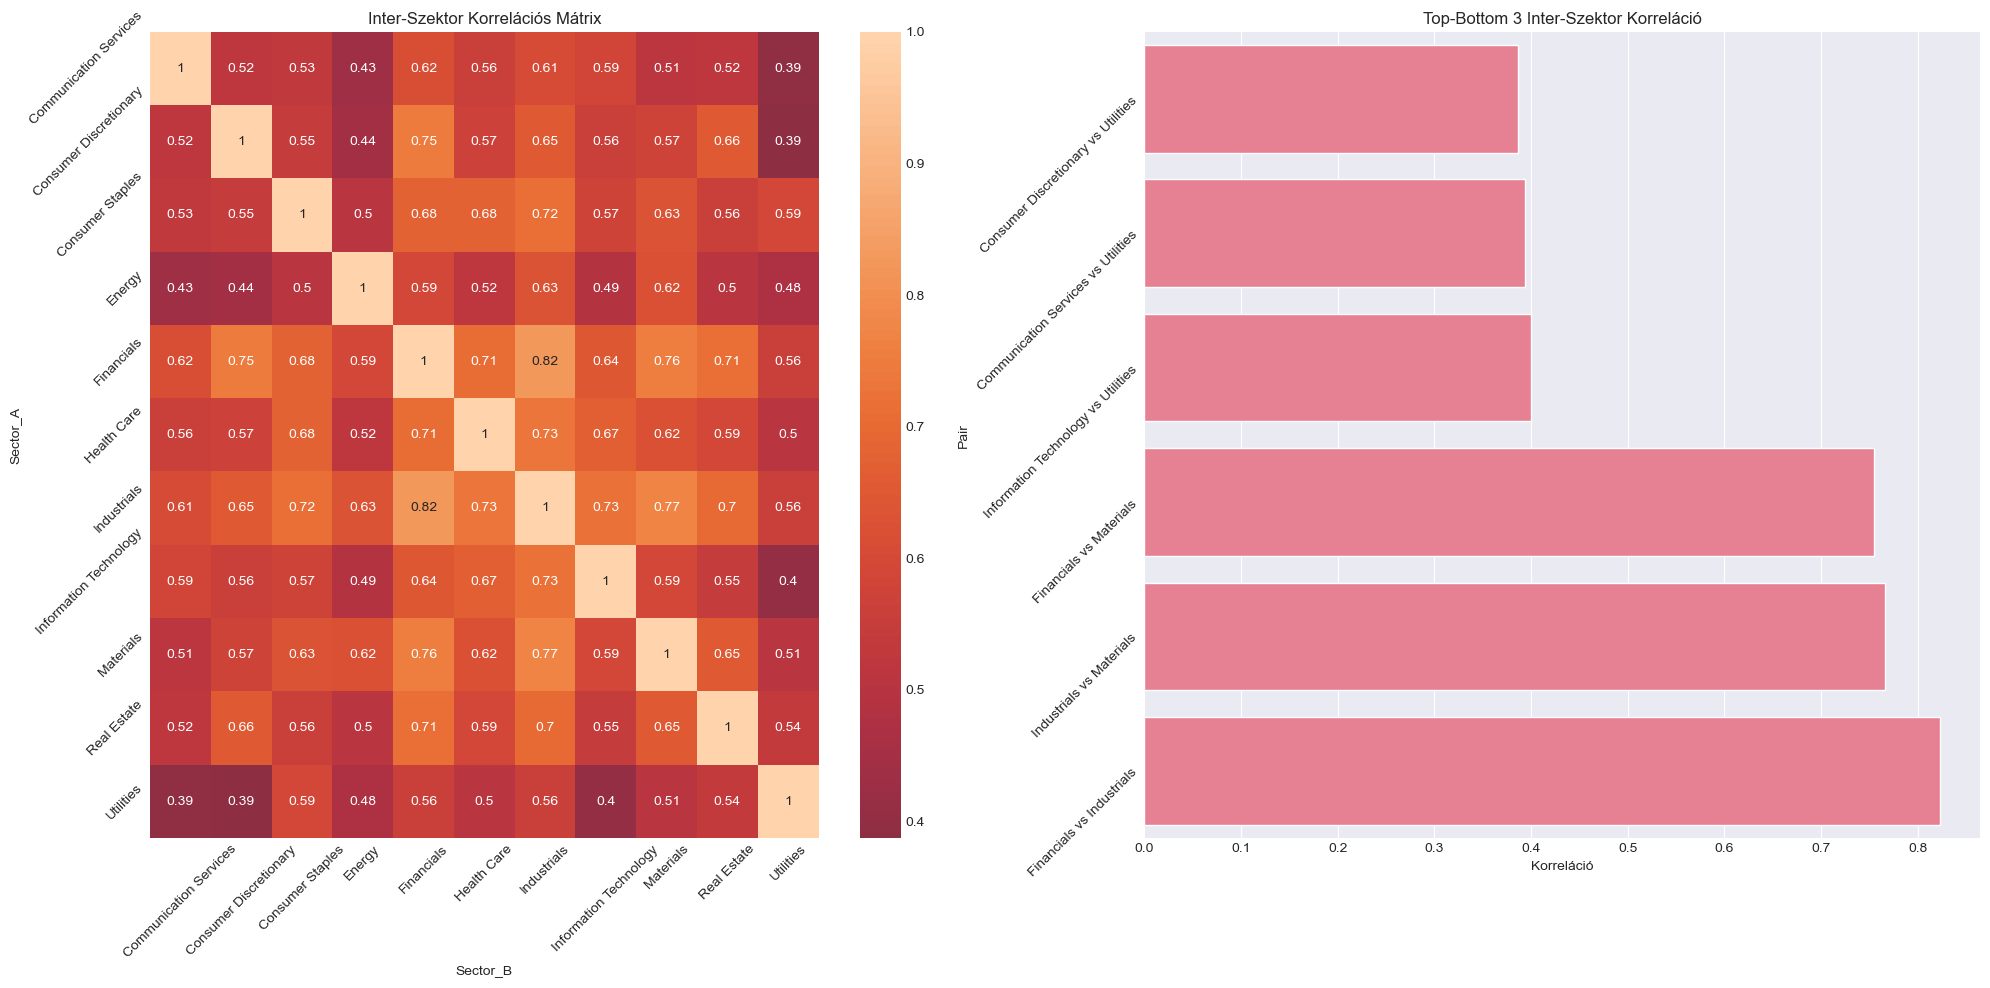

In [335]:
returns_with_sectors = returns_stocks.T.merge(
    sector_map,
    left_index=True,
    right_on='Symbol',
    how='inner'
)

returns_with_sectors.index.name = 'Symbol'
returns_with_sectors.dropna(subset=['Sector'], inplace=True)

sector_returns = returns_with_sectors.groupby('Sector').mean().T
sector_returns.index = pd.to_datetime(sector_returns.index)


sector_corr_matrix = sector_returns.corr()
sector_corr_matrix.index.name = 'Sector_A'
sector_corr_matrix.columns.name = 'Sector_B'

corr_df_sector = sector_corr_matrix.stack().reset_index()
corr_df_sector.columns = ['Sector_A', 'Sector_B', 'Correlation']

corr_df_filtered = corr_df_sector[
    (corr_df_sector['Sector_A'] < corr_df_sector['Sector_B'])
].copy()

N = 3
top_pos = corr_df_filtered.sort_values(by='Correlation', ascending=False).head(N)
top_neg = corr_df_filtered.sort_values(by='Correlation', ascending=True).head(N)

plot_data = pd.concat([top_pos, top_neg]).sort_values(by='Correlation', ascending=True)
plot_data['Pair'] = plot_data['Sector_A'] + ' vs ' + plot_data['Sector_B']


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(sector_corr_matrix, annot=True, center=0, ax=axes[0])
axes[0].set_title("Inter-Szektor Korrelációs Mátrix")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=45)
axes[0].set_ylabel(sector_corr_matrix.index.name)
axes[0].set_xlabel(sector_corr_matrix.columns.name)


ax = sns.barplot(x='Correlation', y='Pair', data=plot_data, ax=axes[1])
axes[1].set_title(f"Top-Bottom {N} Inter-Szektor Korreláció")
axes[1].tick_params(axis='y', rotation=45)
axes[1].set_xlabel("Korreláció")

plt.tight_layout()
plt.show()

Magas Pozitív Korreláció: Ezek a párok (pl. Consumer Discretionary vs. Industrials, Information Technology vs. Communication Services) 0.7 feletti korrelációval rendelkeznek.
 - Pénzügyi Ok: Ezek a szektorok ciklikusak vagy növekedési fázisban lévők, és szoros függőségben állnak az általános gazdasági hangulattal.
 - Mozgás: Ha a gazdasági növekedés erős, a fogyasztás nő,  a technológiai befektetések megindulnak, ekkor ezek a szektorok egyszerre emelkednek, ellenkező esetben szintén hasonlóan esnek.
 - A klaszterezésnél ezen magas korrelációjú szektorok részvényeit nagyobb eséllyel fogja téveszteni

Alacsony/Negatív Korreláció: Ezek a párok (pl. Information Technology vs. Utilities, Consumer Staples vs. Energy) a skála alján helyezkednek el, gyakran 0.4 alatt.
 - Pénzügyi Ok: Ezek a párok eltérő gazdasági faktorokra reagálnak, néha ellentétes irányba is mozognak.
 - A közművek és az alapvető fogyasztási cikkek defenzív szektorok. Ezek a cégek stabil cash flow-val rendelkeznek, és az emberek recesszió alatt is veszik a termékeiket. Amikor a piac egésze esik, a defenzív szektorok jobban tartják magukat.
 - Kamatérzékenység: A Utilities szektor árfolyama érzékeny a kamatlábakra, míg a Growth szektorok inkább  a jövőbeli kilátásokra.
 - A klaszterezésnél ezen szektorok közti tévesztés valószínűsége alacsony lesz

### Hierarchikus klaszterezés

Végül jöjjön a klaszterezés és annak kiértékelése

 - Távolságmátrix létrehozása: A korreláció önmagában nem távolság, ezért a kód átalakítja azt:  korrelációt (1 - corr) formára hozza, majd gyököt von belőle. Ezáltal ha két részvény korrelációja 1, a távolságuk 0 lesz.
 - A squareform függvény egy tömörített formátumot készít, amit az algoritmus hatékonyabban kezel. Ezt eleinte kihagytam, de miközben optimalizálási eszközöket kerestem tatláltam rá, egy LLM segítségével
 - Ward-távolság használata, mely úgy csoportosít, hogy a csoporton belüli szórásnégyzet növekedése minimális legyen
 - Dendogram elvágása, hogy 11 klaszter jöjjön létre, melyeket később megfeleltetek egyes szektoroknak


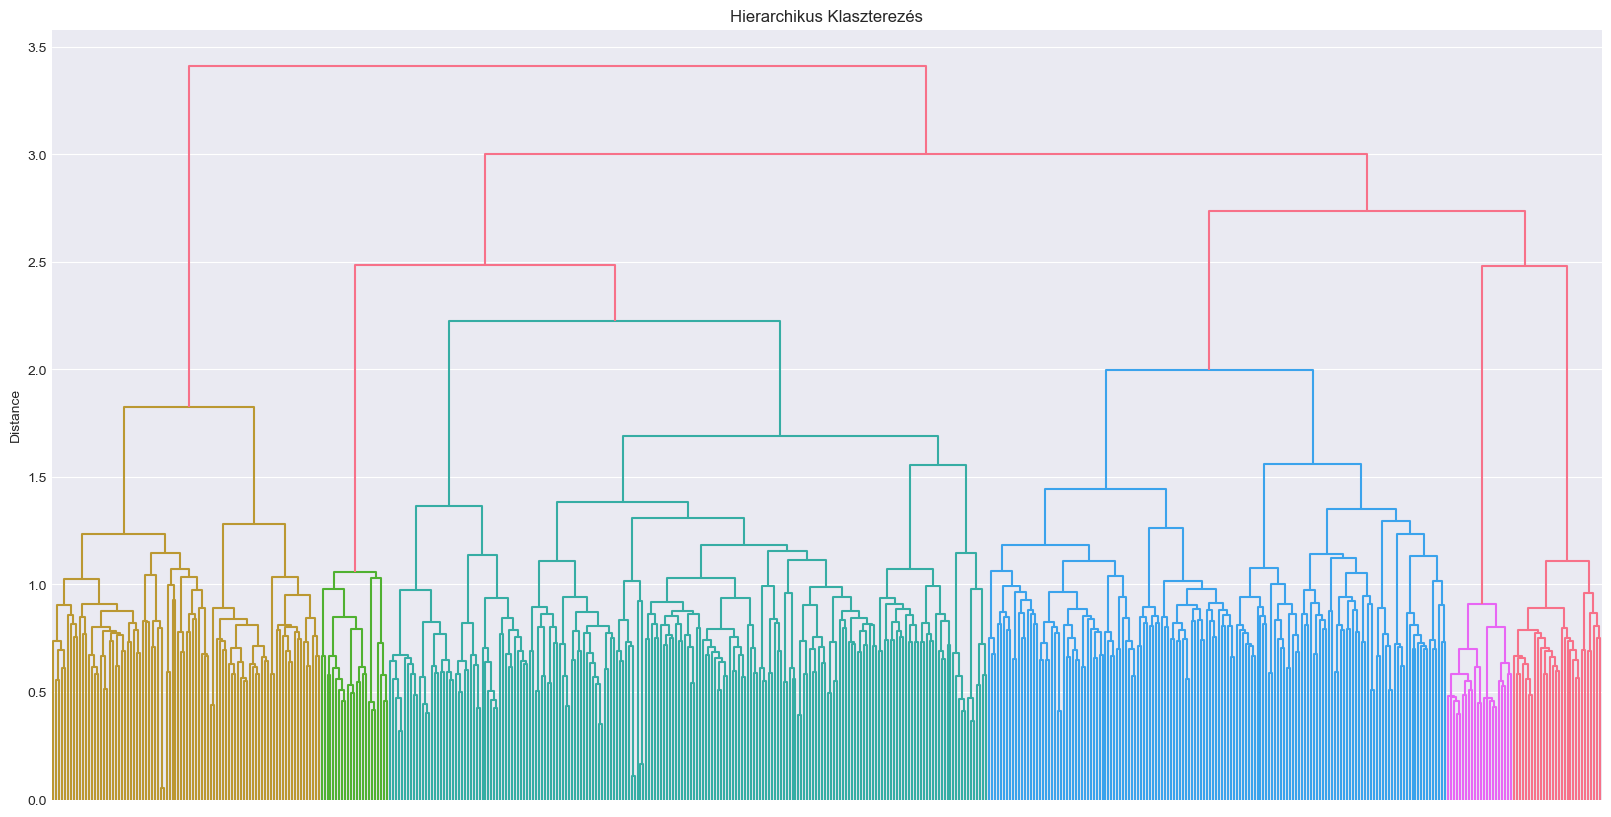

In [337]:


dist = np.sqrt(1 - corr_matrix)
dist_condensed = squareform(dist, checks=False)

linkage_result = linkage(dist_condensed, method="ward")

plt.figure(figsize=(20, 10))

dendrogram(linkage_result, orientation='top', labels=corr_matrix.columns.tolist())
plt.xticks([])
plt.title("Hierarchikus Klaszterezés")
plt.ylabel("Distance")
plt.show()

num_clusters = 11 ##Ennyi szektor van
clusters = fcluster(linkage_result, num_clusters, criterion='maxclust')

cluster_df = pd.DataFrame({
    'Symbol': returns_stocks.columns,
    'Cluster': clusters
})

### Klaszterezés kiértékelése

A kiértékeléshez a *linear_sum_assignment* segítségével a program megkeresi az optimális párosítást a számokkal jelölt klaszterek és a szöveges szektorok között. Úgy rendeli hozzá például a "0. klasztert" a "Technológiához", hogy az a lehető legtöbb helyes találatot eredményezze a teljes adathalmazon. Erre az algoritmusra is LLM-el való beszélgetés során akadtam, és utánanáztem, majd beleépítettem a programomba.

Accuracy after mapping:                  0.5800
Macro F1:                                0.6166
Average cluster purity:                  0.7833

Adjusted Rand Index:                     0.3746
Normalized Mutual Information:           0.5988



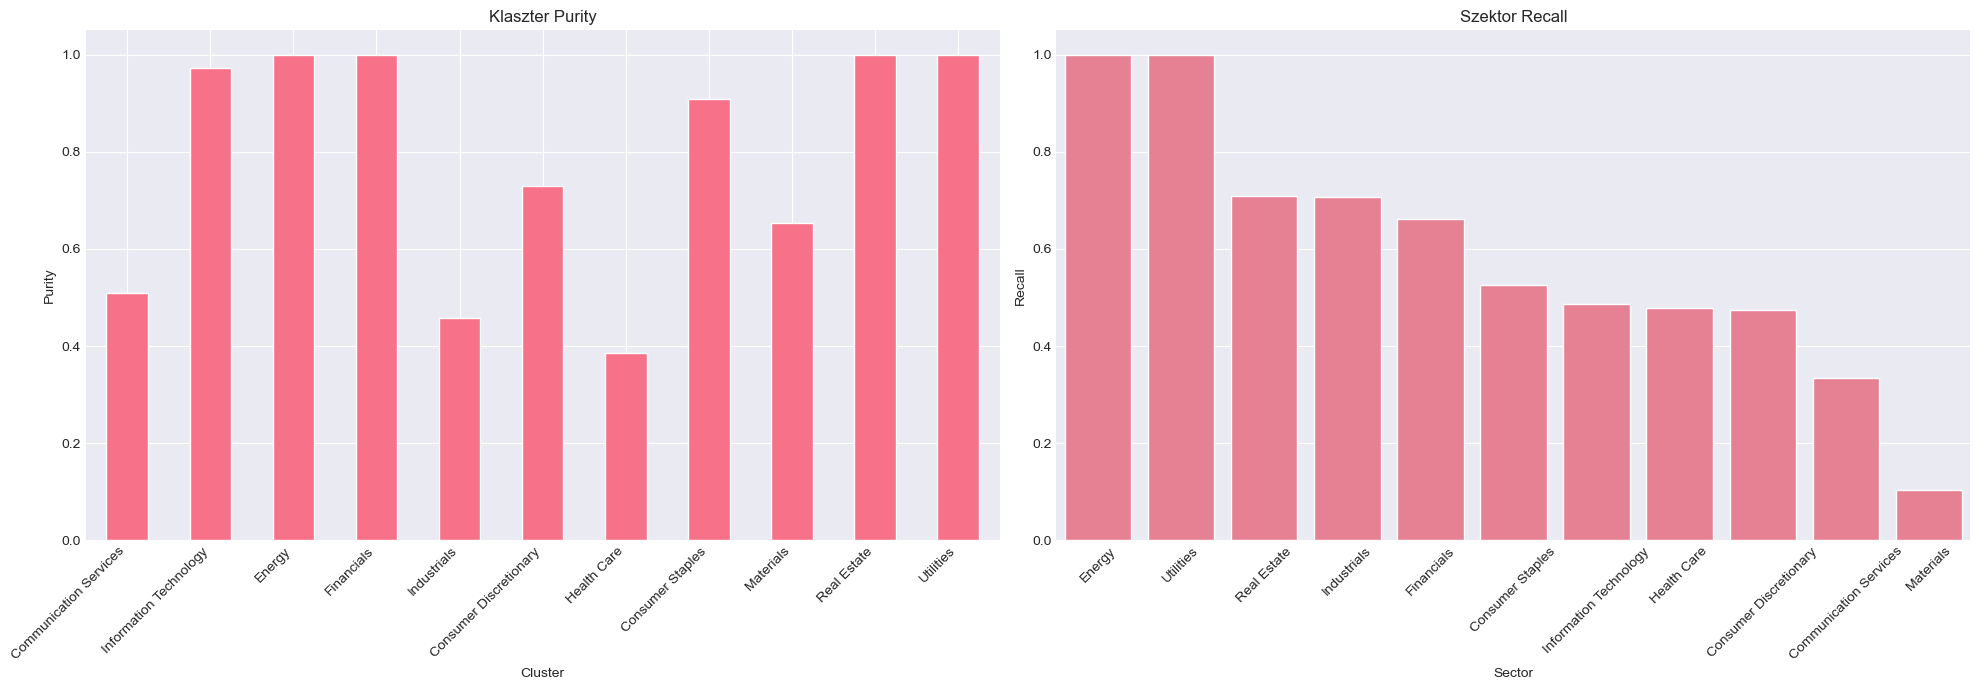

In [312]:
# 1. Szektor Adatok Egyesítése és Tisztítása
init_comparison_df = pd.merge(cluster_df, sector_map, on='Symbol', how='left')
comparison_df = init_comparison_df.dropna(subset=['Sector']).copy()

clusters_pred = comparison_df['Cluster'].values
sectors_true = comparison_df['Sector'].values

# Hungarian Algorithm
ct = pd.crosstab(comparison_df["Sector"], comparison_df["Cluster"]) ##Gyakorisági táblázat: sorok a szektorok, az oszlopok a klaszterek

#-ct.values azért kell, mert az algoritmus alapvetően költséget minimalizál, mi viszont a találatokat akarjuk maximalizálni
row_idx, col_idx = linear_sum_assignment(-ct.values)
best_matches = {ct.columns[c]: ct.index[r] for r, c in zip(row_idx, col_idx)} ##Dict létrehozása

#Metrikák
le = LabelEncoder()
y_true = le.fit_transform(comparison_df["Sector"])
y_pred_raw = comparison_df["Cluster"].values
mapped_sector = comparison_df["Cluster"].map(best_matches)
y_pred = le.transform(mapped_sector)

purity = (comparison_df.groupby("Cluster")["Sector"].agg(lambda s: s.value_counts(normalize=True).max()).sort_index())

recall_df = pd.DataFrame({'Sector': le.classes_,'Recall': recall_score(y_true, y_pred, average=None)})
recall_df = recall_df.sort_values(by='Recall', ascending=False).set_index('Sector')


print(f"Accuracy after mapping:                  {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:                                {f1_score(y_true, y_pred, average="macro"):.4f}")
print(f"Average cluster purity:                  {purity.mean():.4f}\n")

print(f"Adjusted Rand Index:                     {adjusted_rand_score(y_true, y_pred_raw):.4f}")
print(f"Normalized Mutual Information:           {normalized_mutual_info_score(y_true, y_pred_raw):.4f}\n")


fig, ax = plt.subplots(1,2,figsize=(20, 7))

purity.plot(kind="bar", ax=ax[0])
ax[0].set_title("Klaszter Purity")
ax[0].set_ylabel("Purity")
ax[0].set_xticklabels([best_matches[i] for i in purity.index], rotation=45, ha="right")

sns.barplot(x=recall_df.index, y='Recall', data=recall_df, ax=ax[1])
ax[1].set_title('Szektor Recall')
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Sector')
ax[1].tick_params(axis='x', rotation=45)

fig.tight_layout()
fig.show()



 - Adjusted Rand Index: Ez a klaszterezés és a valós besorolás közötti hasonlóságot méri, korrigálva a véletlen egyezés lehetőségével. Az 1.0-hoz képest alacsony, azt jelzi, hogy a korreláció alapú klaszterezés nem egyezik szorosan a hivatalos szektorális besorolással, még a véletlen hatásának kiszűrésével sem. Ez a hipotézis elutasításának legfőbb alapja.
 - Normalized Mutual Information: Azt méri, hogy mennyi információt oszt meg a klaszterezés a valós szektorokkal. A közepes érték megerősíti, hogy van átfedés, de a két csoportosítás nem azonos.
 - Average cluster purity: A 75% feletti érték azt jelenti, hogy a korreláció alapján létrehozott csoportok belsőleg nagyon homogének. Ha egy részvény bekerül egy klaszterbe, nagy valószínűséggel a többi részvény is ugyanahhoz a domináns szektorhoz tartozik. Ez igazolja, hogy a Ward klaszterezés hatékonyan hozott létre jól elkülönülő csoportokat.
 - Accuracy after mapping: A korreláció alapján besorolt részvények kb. fele került a hivatalos szektorához optimálisan hozzárendelt klaszterbe. Ez a mérték megerősíti, hogy a hipotézis részben állja meg a helyét, mert a véletlenszerű csopostosítás sokkal alacsonyabb eredményt ért volna el, de az egyezés csak mérsékelt
 - Macro F1: Hasonlóan az Accuracy-hez, a közepes érték a mérsékelt, de nem tökéletes egyezést mutatja, figyelembe véve a szektorok méretét is.
 - A recall grafikonon megfigyelhető. hogy a sorrend hasonlít a korábbi szektoron belüli átlagos korrelációt ábrázoló grafikonra, ami logikus, mivel a korreláció mértéke alapján osztályozzuk a részvényeket. A külömbségek abból adódnak, hogy nem csak a tömörség (korreláció), hanem az elkülönültség is számít. Például a Health Care nem tömör a többihez képest, viszont mivel eléggé elkülönült, relatív jó a recall. Viszont a Materials tömörsége hasonló a Health Care-hez, de mivel nincs annyira elkükönülve, ezért szétszóródik a többi klaszter közt.


A klaszterezés sikeresen bebizonyította, hogy a defenzív szektorok (Közművek, Energia) és a nyersanyagok rendkívül egyedi statisztikai profillal rendelkeznek, így ezeket könnyű "felfedezni". Azonban a ciklikus szektorok (Consumer Discretionary, Industrials) esetében a korreláció alapú távolság nem elegendő. Ezek a cégek gyakran más szektorokhoz hasonlóan viselkednek (pl. az Amazon technológiai cégként, a Tesla növekedési papírként mozog), ami megzavarja a tiszta szektor-alapú felosztást.


Összegzés: Adjusted Rand Index (ARI) alacsony értéke (0.2900) alapján a hipotézis, miszerint a korreláció szerinti csoportosítással pontosan szektorokra lehet bontani a részvényeket, elutasítható. Azonban az Average Cluster Purity (0.7553) magas értéke azt mutatja, hogy a klaszterezés nem véletlenszerű. A kapott csoportok viselkedésileg hasonlóak, ami azt jelenti, hogy a korreláció szektorokon átívelő viselkedési csoportokat (pl. növekedési részvények, kamatérzékeny részvények) azonosít, nem pedig kizárólag a hivatalos szektorokat.

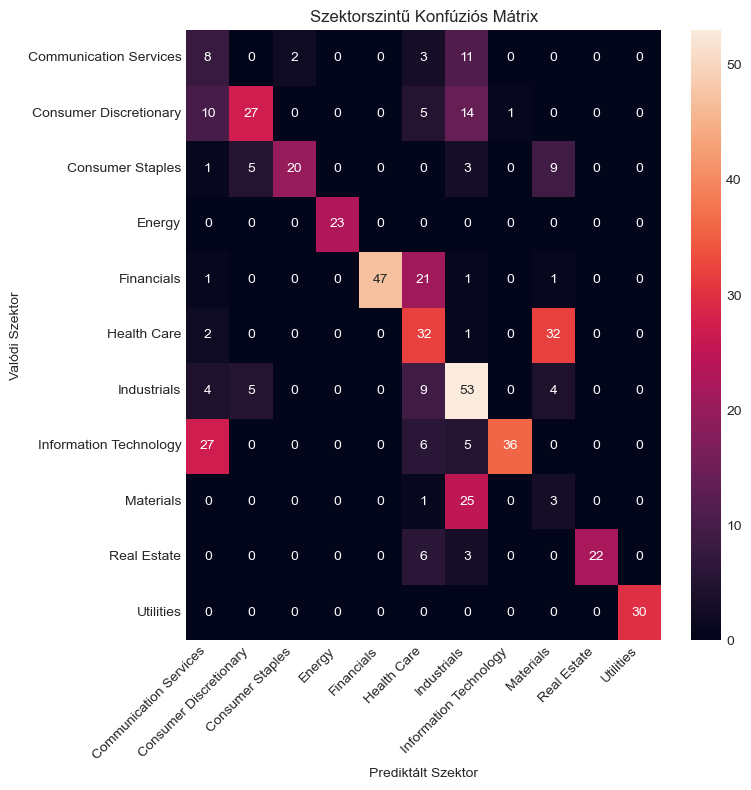

In [313]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Szektorszintű Konfúziós Mátrix')
plt.xlabel('Prediktált Szektor')
plt.ylabel('Valódi Szektor')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

1. A "Tiszta" Szektorok (Magas Recall)
Vannak szektorok, amelyek az árfolyammozgásuk alapján élesen elkülönülnek a piactól:
 - Energy & Utilities: Ezek tökéletesen különülnek el (Energy: 23/23, Utilities: 30/30). Ez logikus, hiszen ezeket a szektorokat egyedi fundamentális tényezők (pl. olajár, szabályozott közműdíjak) mozgatják.
 - Real Estate: Szintén erős (22/31), bár 6 papír a Health Care klaszterbe „tévedt”.

2. Jelentős átfedések és "Összeolvadások"
 - Information Technology vs. Communication Services: 27 IT-szektorbeli részvényt a Communication Services-be sorolt a modell. Ez érthető, hiszen sok tech óriás és kommunikációs cég korrelációja rendkívül magas.
 - Financials vs. Health Care: 21 pénzügyi papír került a Health Care klaszterbe. Ez egy meglepőbb összefüggés, ami arra utalhat, hogy bizonyos piaci ciklusokban ezek a papírok hasonló defenzív vagy növekedési karakterisztikát mutattak.
 - Health Care vs. Materials: 32 Health Care papír a Materials klaszterbe került, ami szintén jelentős torzítás.

 3. A "Szuper-szektorok" és a domináns Industrials klaszter: A legszembetűnőbb jelenség az Industrials oszlop. Látható, hogy rengeteg más szektorból kerültek ide cégek. Ez arra utal, hogy létezik egy "általános piaci mozgás", amit az algoritmus az Industrials klaszterbe sűrített. Az Industrials szektor cégei gyakran közepes korrelációt mutatnak szinte mindennel, így ez egyfajta "gyűjtőkosár" lett.

# Modellépítés Szektor predikcióra korreláció alapján

Adatok előkésítése után összehasonlítok több klasszifikációs modellt.

## Optimális komponensszám meghatározása


A részvények közötti korrelációs mátrix rendkívül magas dimenziószámú adat, amelyben minden egyes részvény egy újabb dimenziót jelent. Ezek gyakran tartalmaznak „zajt”, amelyek rontják a klaszterező algoritmusok hatékonyságát és pontosságát.


A dimenziócsökkentés céljából PCA-t alkalmazok. A folyamat során a célom nem egy előre meghatározott számú komponens kiválasztása volt, hanem egy olyan dinamikus megközelítés alkalmazása, amely az adatok belső varianciájára épít.


Ehhez az alábbi logikai lépéseket követtem:
 - Standardizálás: Mivel a PCA érzékeny az adatok skálájára, a korrelációs mátrixot először standardizáltam.
 - Teljes variancia feltérképezése: Első lépésben egy korlátozás nélküli PCA-t futtattam az összes lehetséges főkomponens kinyerésére.
 - Kumulatív magyarázó erő: Kiszámítottam a főkomponensek által magyarázott variancia kumulatív összegét. Ez megmutatja, hogy az első *k* számú komponens együttesen az eredeti információmennyiség mekkora részét őrzi meg.
 - Küszöbérték (Threshold) meghatározása: Meghatároztam egy 85%-os küszöböt, ami elég magas ahhoz, hogy a piaci struktúra lényeges elemeit megtartsa, de elég alacsony ahhoz, hogy jelentősen egyszerűsítse a modellt és kiszűrje a statisztikai zajt.


Az ötlet, hogy úgy így határozom meg a komponensek számát az enyém volt, viszont a megvalósításhoz egy LLM segíségét használtam fel.


In [314]:
X_std = StandardScaler().fit_transform(corr_matrix)
pca_full = PCA(n_components=None).fit(X_std)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

threshold = 0.85
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"A variancia {threshold*100:.0f}%-át magyarázó komponensek száma: {num_components}")

A variancia 85%-át magyarázó komponensek száma: 14


Az algoritmus szerint 14 főkomponens elegendő ahhoz, hogy a piaci mozgások 85%-át lefedjük, ami jelentős dimenziócsökkentést jelent az eredeti részvényszámhoz képest, miközben a releváns információk döntő többsége megmarad.

## Adatok előkészítése

A dimenziócsökkentés után a modell számára szükséges jellemzőmátrix és célváltozó előállítása.

Mivel a PCA során kinyert főkomponensek önmagukban csak absztrakt értékek, ezeket össze kell kapcsolni a szektorokkal.

A munkafolyamat lépései:

 - PCA: A korábban meghatározott optimális komponensszám alkalmazásával elvégeztem a tényleges vetítést. Az eredményeket egy új DataFrame-be rendeztem, ahol minden részvényt a legfontosabb főkomponensei reprezentálnak.
 - Adatok Összefűzése: A pca_df-et és a sector_map-et egyesítettem: csak azok a részvények kerülnek a modellbe, amelyekről rendelkezésre állt korrelációs adat az árfolyammozgásuk alapján, és van hozzájuk rendelt hivatalos szektorbesorolás is.
 - Célváltozó Kódolása: Mivel a gépi tanulási algoritmusok numerikus értékekkel dolgoznak, a szöveges szektorneveket a LabelEncoder segítségével egészekké alakítottam.
 - Rétegzett Felosztás (Stratified Split): Ez elengedhetetlen a tőzsdei adatoknál, mivel a szektorok mérete egyenlőtlen. A rétegzés biztosítja, hogy mindkét halmazban azonos maradjon a szektorok százalékos eloszlása, megelőzve ezzel, hogy a modell „vakon” maradjon a ritkább kategóriákra.

In [315]:
pca = PCA(n_components=num_components, random_state=random_state)
X_pca = pca.fit_transform(corr_matrix)

pca_df = pd.DataFrame(
    X_pca,
    index=corr_matrix.index,
    columns=[f'PC{i+1}' for i in range(num_components)]
)

data = pca_df.join(sector_map, how='inner')

X = data.drop(columns=['Sector']).values
y = data['Sector'].values

# Encode sector labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.20,
    random_state=random_state,
    stratify=y_encoded ## A split megtartja az osztályok arányát, hogy ne legyen olyan, hogy pl nem jut Materials a train halmazba
)

## display(data)


## Modellek
A korábban kinyert 14 főkomponens önmagában még csak nyers bemeneti adat. Most ki fogok próbálni több különböző modellt, majd kiértékelem a kapott eredményeket.


### Random Forest

Ahhoz, hogy a lehető legpontosabb előrejelzést kapjuk, a GridSearchCV eljárást alkalmaztam. Ez a módszer szisztematikusan végigpróbálja a modell paramétereinek (fák száma, mélység, döntési kritérium) különböző kombinációit, és keresztvalidáció segítségével választja ki azt a konfigurációt, amely a legáltalánosabb és legstabilabb eredményt adja.

In [316]:
param_grid_rf = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=random_state)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,            # 5-szörös keresztvalidáció
    scoring='accuracy'
)

grid_search_rf.fit(X_train, y_train)

print(f"Legjobb paraméterek: {grid_search_rf.best_params_}")
print(f"Legjobb keresztvalidációs pontosság: {grid_search_rf.best_score_:.3f}")

best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_rf:.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Legjobb paraméterek: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Legjobb keresztvalidációs pontosság: 0.790
Accuracy: 0.817
                        precision    recall  f1-score   support

Communication Services       0.75      0.60      0.67         5
Consumer Discretionary       0.71      0.45      0.56        11
      Consumer Staples       1.00      0.75      0.86         8
                Energy       1.00      1.00      1.00         5
            Financials       0.72      0.93      0.81        14
           Health Care       1.00      1.00      1.00        13
           Industrials       0.71      0.80      0.75        15
Information Technology       0.68      0.87      0.76        15
             Materials       1.00      0.67      0.80         6
           Real Estate       1.00      0.83      0.91         6
             Utilities       1.00      1.00      1.00         6

              accuracy                           0.82       104

A modell 81.7%-os pontossága a teszt halmazon erős predikciós teljesítményre utal.

Főbb megállapítások:

 - Tökéletesen elkülönülő szektorok: Az Energy, Health Care és Utilities szektorok esetében a modell hibátlanul teljesített. Ezek a szektorok tehát olyan egyedi korrelációs mintázattal rendelkeznek, amely élesen elválik a piac többi részétől.
 - "Tech-zavar": Az Information Technology (Recall: 0.87) és Communication Services (Recall: 0.60) közötti korábbi nagy átfedés jelentősen csökkent. A modell megtanulta azokat a különbségeket a PCA-térben, amiket a korábbi klaszterező algoritmus még nem látott.
 - Nehézségek: A Consumer Discretionary szektor bizonyult a legnehezebb feladatnak (F1: 0.56). Ez arra utal, hogy a fogyasztási cikkek gyártói a piaci mozgásuk alapján gyakran hasonlítanak az ipari vagy technológiai papírokhoz.

### Gradient boosting

Miután a Random Foresttel sikerült egy alapszintet felállítani, a Gradient Boosting Classifier-t is megvizsgálom, hogy milyen teljesítményt ér el. Míg a Random Forest az átlagolásra épít, a Gradient Boosting egy optimalizációs folyamat, amely minden egyes új fa hozzáadásakor a gradiens mentén haladva csökkenti a modell veszteségfüggvényét.

A modellt ismét GridSearchCV segítségével optimalizáltam.

In [317]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4]
}

gb = GradientBoostingClassifier(random_state=random_state)

grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=5,            # 5-szörös keresztvalidáció
    scoring='accuracy',
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)

print(f"Legjobb paraméterek: {grid_search_gb.best_params_}")
print(f"Legjobb keresztvalidációs pontosság: {grid_search_gb.best_score_:.3f}")

best_gb = grid_search_gb.best_estimator_
y_pred = best_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_gb:.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Legjobb paraméterek: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 100}
Legjobb keresztvalidációs pontosság: 0.742
Accuracy: 0.788
                        precision    recall  f1-score   support

Communication Services       1.00      0.60      0.75         5
Consumer Discretionary       0.78      0.64      0.70        11
      Consumer Staples       1.00      0.75      0.86         8
                Energy       1.00      0.80      0.89         5
            Financials       0.81      0.93      0.87        14
           Health Care       0.86      0.92      0.89        13
           Industrials       0.59      0.87      0.70        15
Information Technology       0.80      0.80      0.80        15
             Materials       0.50      0.33      0.40         6
           Real Estate       1.00      0.67      0.80         6
             Utilities       0.86      1.00      0.92         6

              accuracy                           0.79       104
             macro avg   

A modell 78.8%-os pontossága kisebb a Random Forest 81.7%-os eredményétől, viszont vannak különbségek:

 - Precizitás: Érdekes, hogy bizonyos szektorokban a GB pontosabb lett. A Communication Services, és Consumer Discretionary szektorokban is kifejezetten jobban teljesít.
 - Érzékenység a zajra: A Materials szektor eredményeinek drasztikus visszaesése arra utal, hogy a Gradient Boosting hajlamosabb volt a "zajra" fókuszálni ennél a kis mintaszámú csoportnál. Ez a modell érzékenyebb a hiperparaméterekre, és a jelek szerint a 14 főkomponens között talált olyan összefüggéseket, amik nem általánosíthatóak jól erre a szektorra.

 A Random Forest robusztusabbnak bizonyult ezen az adathalmazon. A GB max_depth: 2 értéke azt mutatja, hogy a modell nagyon egyszerű fákkal érte el a legjobb eredményt, ami azt jelzi, hogy a mélyebb, komplexebb összefüggések keresése már túltanuláshoz vezetne.

### Support vector classifier

Az SVM alkalmazása a 14 főkomponensre egyfajta "geometriai" megközelítést jelent. Az SVM különlegessége, hogy a döntési határát csak néhány kritikus adatpont határozza meg, ami elméletileg robusztussá teszi a modellt a távoli zajjal szemben.

In [318]:

param_grid_svm = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [100, 125, 150, 175],
    'gamma': ['scale', 'auto', 0.01, 0.0125, 0.015]
}

svm = SVC(random_state=random_state)

grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,            # 5-szörös keresztvalidáció
    scoring='accuracy',
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)

print(f"Legjobb paraméterek: {grid_search_svm.best_params_}")
print(f"Legjobb keresztvalidációs pontosság: {grid_search_svm.best_score_:.3f}")

best_svm = grid_search_svm.best_estimator_
y_pred = best_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_svm:.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Legjobb paraméterek: {'C': 125, 'gamma': 0.0125, 'kernel': 'rbf'}
Legjobb keresztvalidációs pontosság: 0.795
Accuracy: 0.808
                        precision    recall  f1-score   support

Communication Services       0.20      0.20      0.20         5
Consumer Discretionary       0.62      0.45      0.53        11
      Consumer Staples       0.88      0.88      0.88         8
                Energy       1.00      1.00      1.00         5
            Financials       0.88      1.00      0.93        14
           Health Care       1.00      1.00      1.00        13
           Industrials       0.71      0.80      0.75        15
Information Technology       0.71      0.80      0.75        15
             Materials       1.00      0.67      0.80         6
           Real Estate       1.00      0.83      0.91         6
             Utilities       1.00      1.00      1.00         6

              accuracy                           0.81       104
             macro avg       0.82      0.

Az SVM modell eredményei újabb eltéréseket mutatnak a kiértékelésnél. A modell 81%-os pontossága szinte azonos a Random Forest szintjével, de a szektoronkénti bontásban látszanak az SVM specifikus jellemzői.

 - Stabilitás: Az Energy, Health Care és Utilities szektorok itt is tökéletes, 1.00-ás F1-score-t értek el. Ez egyértelmű bizonyítéka annak, hogy ezek a szektorok geometriailag is teljesen elkülönülnek a korrelációs térben.
 - Nehézségek: A Communication Services szektornál az SVM gyengébben teljesített (F1: 0.20), mint a fa-alapú modellek. Ez arra utal, hogy ez a szektor nem alkot egyetlen összefüggő "tömböt" a térben, hanem több apró szigetre szakad, amiket ez a modell nehezebben tud elhatárolni a zajtól.

## Konklúzió

Átfogó értékelés és modell-összehasonlítás:

A kutatás egyik fő kérdése az volt, hogy a részvények árfolyam-korrelációja mennyire hordozza magában a szektor-besorolást. A válasz egyértelműen pozitív: míg a felügyelet nélküli klaszterezés (Accuracy: 0.58) csak a piaci struktúra alapjait találta meg, a felügyelt tanulási modellek (80% feletti pontosság) bebizonyították, hogy az adatokban rejlő összefüggések szinte teljes mértékben alkalmasak a szektor-azonosításra.

A modellek teljesítményének kontrasztja
A különbségi mátrixok (rf-svm, rf-gb, gb-svm) alapján, melyeket excel-ben vizsgáltam és az alábbi konklúziókat vontam le:

Random Forest vs. Többiek: A Random Forest bizonyult a legstabilabbnak a legtöbb szektorban. Az SVM-hez képest előnye van a Communication Services (F1-score különbség: +0.47) és a Consumer Discretionary (+0.03) szektorokban. Ez azt jelzi, hogy a fa-alapú hierarchikus döntések jobban kezelik a térben szétszórt, "szigetszerű" szektorokat.

Gradient Boosting Sikerei: Bár a GB összesített pontossága valamivel alacsonyabb (79%), az SVM-mel szemben kimagaslóan jól teljesített a Communication Services szektorban (+0.55 F1-score különbség). Ugyanakkor az RF-hez képest (rf-gb) alulmaradt a Materials (-0.40) és a Consumer Discretionary (-0.14) terén.

SVM Karakterisztikája: Az SVM geometriai módszere rendkívül precíz a jól elkülönülő szektoroknál, de a különbségi táblázatok lilával jelzett mezői mutatják, hogy a bonyolultabb eloszlású csoportokban (mint a Communication Services vagy a Consumer Discretionary) gyakran elmarad a fa-alapú modellek rugalmasságától.



A vizsgálat igazolta, hogy a részvénypiacon a korreláció alapú dimenziócsökkentés egy rendkívül hatékony jellemző-kinyerési módszer.

A Random Forest a legjobb választás az általános piaci osztályozáshoz (Accuracy: 0.817), mivel ez tudta a legjobban kezelni a zajosabb, átfedő szektorokat.

A Support Vector Machine (SVM) kiváló alternatíva a stabil, nagyvállalati szektorok (Financials, Energy) azonosítására.

A Gradient Boosting bizonyos specifikus szektorokban (pl. Communication) mutatott extra precizitást, de érzékenyebb a kisméretű szektorok (Materials) zajára.

# Összegzés

A házi feladat végére sok új módszerrel megismerkedtem. Alapvető ötletek sajátjaim voltak, viszont alkalmaztam LLM által javasolt javításokat, és ismeretlenebb területeken felhasználtam, hogy jobban el tudjak mélyülni, és megismerni az adott témát, például a modellek hiperparaméter optimalizációja, és a grafikonok megjelenítésének különböző módszerei, beállításai.

A jövőben kiváncsi lennék, az elemzéseimet hogy befolyásolná a piaci kapitalizáció alapú súlyozás. Mire a végére jutottam, több olyan gondolatom is volt amik nem kerültek bele a kész feladatba, ezek közül például az inflációs rezsim prediktálása különböző modellekkel a hozamok alapján, a cégek IPO dátumainak és a piaci kapitalizáció közti kapcsolat vizsgálata és a részvények közti korreláció változása bizonyos inflációs rezsimekben. Emellett a későbbiekben szivesen belemélyednék konkrét cégek részletesebb vizsgálatába, amihez nyilván nem csak az árfolyamot, és inflációs kötnyezetet használnám fel.